# Marketing campaign prediction

# Outline
- [ 1 - Big Picture ](#1)
    - [data description](#1.1)
    - [problem statement and objective](#1.2)
- [ 2 -  Setup](#2)
    - [packages](#2.1)
    - [utilities](#2.2)
    - [datasets](#2.3)
- [ 3 - EDA](#3)
    - [individual distributions](#3.1)
    - [correlation](#3.2)
        - [numerical features vs target](#3.3)
        - [categorical features vs target](#3.4)
        - [feature combinations](#3.5)
- [ 4 - Preprocessing](#4)
- [ 5 - Dimension reduction and Visualization](#5)
- [ 6 - Modeling](#6)
    - [baseline models](#6.1)
    - [hyperparameter tuning](#6.2)
- [7 - Resampling](#7)
    - [oversampling](#7.1)
        - [random oversampling](#7.1.1)
        - [SMOTE](#7.1.2)
        - [ADASYN](#7.1.3)
    - [undersamping](#7.2)
        - [random downsampling](#7.2.1)
        - [Tomek's link](#7.2.2)


<a name="1"></a>
# 1 - The big picture

## Data description<a name="1.1"></a>

- The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed. ([Moro et al., 2011])


- There are 45,211 instances for bank-full.csv, including 36,169 training data and 9,042 test data. Both data contain 16 input variables + 1 target variable.


### Attribute information:

##### bank client data
    1. age (numeric)
    2. job: type of job ("admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
       "blue-collar","self-employed","retired","technician","services") 
    3. marital: marital status ("married","divorced","single"; note: "divorced" means divorced or widowed)
    4. education: ("unknown","secondary","primary","tertiary")
    5. default: has credit in default? (binary: "yes","no")
    6. balance: average yearly balance, in euros (numeric) 
    7. housing: has housing loan? (binary: "yes","no")
    8. loan: has personal loan? (binary: "yes","no")
##### related with the last contact of the current campaign:
    9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
    10. day: last contact day of the month (numeric)
    11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
    12. duration: last contact duration, in seconds (numeric)
##### other attributes:
    13. campaign: number of contacts performed during this campaign for this client(numeric, includes last contact)
    14. pdays: number of days passed by after the client was last contacted from previous campaign 
        (numeric, -1 means client was not previously contacted)
    15. previous: number of contacts performed before this campaign and for this client (numeric)
    16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
##### output variable (desired target):
    17. y - has the client subscribed a term deposit? (binary: "yes","no")


## Problem statement and objective
This is a classification task where we want to predict if the client will subscribe a term deposit (`y=1`).

Due to the skewed nature of the classes, our objective will be to achieve a higher recall and precision on the positive class.

<a name="2"></a>
# 2 - Set up

## packages <a name="2.1"></a>

In [66]:
# import libraries and run a few checks
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import scipy.stats as stats
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set(palette='Paired', style='white')

import warnings 
warnings.filterwarnings('ignore')

## utilities <a name="2.2"></a>

In [67]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


# utility function to save figures for presentation
# use it like save_fig('figure_name')
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# util to reduce memory usage
## From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:.2f} Mb ({1-end_mem/start_mem:.2%} reduction)')
    return df


# summarize outliers for numerical columns
def summarize_outliers(df_num, n_std=3):
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    margin = data_std * n_std
    lower, upper = data_mean - margin, data_mean + margin
    
    res = pd.DataFrame(df_num.apply(axis=0, func=lambda x: np.sum(x < lower[x.name])), columns=['n_lower'])
    res['n_higher'] = df_num.apply(axis=0, func=lambda x: np.sum(x > upper[x.name])).values
    res['n_outliers'] = res['n_lower'] + res['n_higher']
    res['%_outliers'] = (res['n_outliers'] / df_num.notnull().sum() * 100).round(2)

    return res


# utils to plot neural network loss
def plot_loss(history, label, n):
    plt.plot(history.epoch, 
             history.history['loss'],
             color=colors[n], 
             label='Train ' + label)
    plt.plot(history.epoch, 
             history.history['val_loss'],
             color=colors[n], 
             label='Test ' + label,
             linestyle='--')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    

# utils to plot neural network performance
def plot_metrics(history):
    plt.figure(dpi=200, figsize=(12, 10))
    metrics = ['accuracy', 'precision', 'recall', 'prc']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, 
                 history.history[metric], 
                 color=colors[1],
                 label='Train')
        plt.plot(history.epoch, 
                 history.history['val_' + metric], 
                 color=colors[1],
                 label='Test',
                 linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout(pad=1.5)
    

# utils to plot neural network precision-recall curve
def plot_prc(label, y_true, y_pred, **kwargs):
    # drop thresholds _
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_true, y_pred)
    plt.plot(precision, recall, label=label, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')    

## datasets <a name="2.3"></a>

In [262]:
train = pd.read_csv('traininingdata.txt', sep=';')
test = pd.read_csv('testdata.txt', sep=';')

In [69]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


In [263]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage decreased to 3.21 Mb (31.62% reduction)
Memory usage decreased to 0.79 Mb (32.35% reduction)


In [71]:
train['y'].replace({'yes': 1, 'no': 0}, inplace=True)
test['y'].replace({'yes': 1, 'no': 0}, inplace=True)

<a name='3'></a>
# 3 - EDA

First, let us take a look at train data

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        36168 non-null  int8  
 1   job        36168 non-null  object
 2   marital    36168 non-null  object
 3   education  36168 non-null  object
 4   default    36168 non-null  object
 5   balance    36168 non-null  int32 
 6   housing    36168 non-null  object
 7   loan       36168 non-null  object
 8   contact    36168 non-null  object
 9   day        36168 non-null  int8  
 10  month      36168 non-null  object
 11  duration   36168 non-null  int16 
 12  campaign   36168 non-null  int8  
 13  pdays      36168 non-null  int16 
 14  previous   36168 non-null  int16 
 15  poutcome   36168 non-null  object
 16  y          36168 non-null  int64 
dtypes: int16(3), int32(1), int64(1), int8(3), object(9)
memory usage: 3.2+ MB


No missing data.

In [73]:
# numerical columns
num_cols = train.describe().columns.to_list()[:-1]
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.942076,1365.055989,15.778534,258.363166,2.769907,39.749889,0.579601,0.116982
std,10.616610,3098.191637,8.313360,257.188052,3.119367,99.547099,2.384831,0.321403
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1422.250000,21.000000,320.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


Imbalanced classes: only **11.7%** clients subscribed to a term deposit.

Let's get specific counts of the classes.

In [74]:
total = len(train)
neg, pos = np.bincount(train['y'])
print(f'Examples: {total}\n    negative: {neg}\n    positive: {pos} ({pos/total:.2%})')

Examples: 36168
    negative: 31937
    positive: 4231 (11.70%)


In [75]:
summarize_outliers(train[num_cols])

,n_lower,n_higher,n_outliers,%_outliers
age,0,311,311,0.86
balance,1,569,570,1.58
day,0,0,0,0.00
duration,0,781,781,2.16
campaign,0,675,675,1.87
pdays,0,1402,1402,3.88
previous,0,475,475,1.31


Notice we have mostly outliers on the higher end, meaning these distributions are probably right-skewed, consider log transformation to normalize.

In [76]:
# non-numerical columns
cat_cols = train.describe(include=['O']).columns.to_list()
train.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,36168,36168,36168,36168,36168,36168,36168,36168,36168
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,7804,21795,18556,35518,20031,30399,23380,11034,29623


## Invidual distributions <a name="3.1"></a>

For numerical features, let's examine each histogram to understand the distribution.

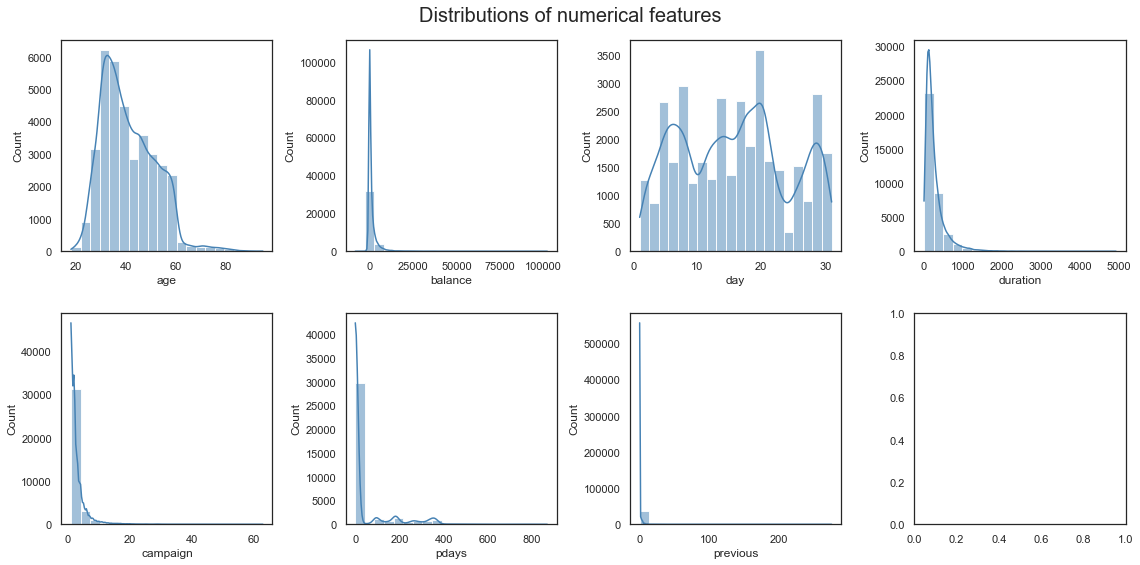

In [77]:
# numerical features
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for col, ax in zip(num_cols, axes.flat):
    sns.histplot(x=col, data=train, bins=20, kde=True, ax=ax, color='steelblue')
fig.suptitle('Distributions of numerical features', fontsize=20)
plt.tight_layout(h_pad=2)

#save_fig("num_cols_distribution_plots")

> for highly skewed features, consider log transformation to give a more normal semblance

In [78]:
train['balance_log'] = np.log(train.balance + 10000)
train['duration_log'] = np.log(train.duration + 0.01)
train['campaign_log'] = np.log(train.campaign + 0.01)
train['pdays_log'] = np.log(train.pdays + 1.01)

For categorical features, let's plot countplot to understand each distribution.

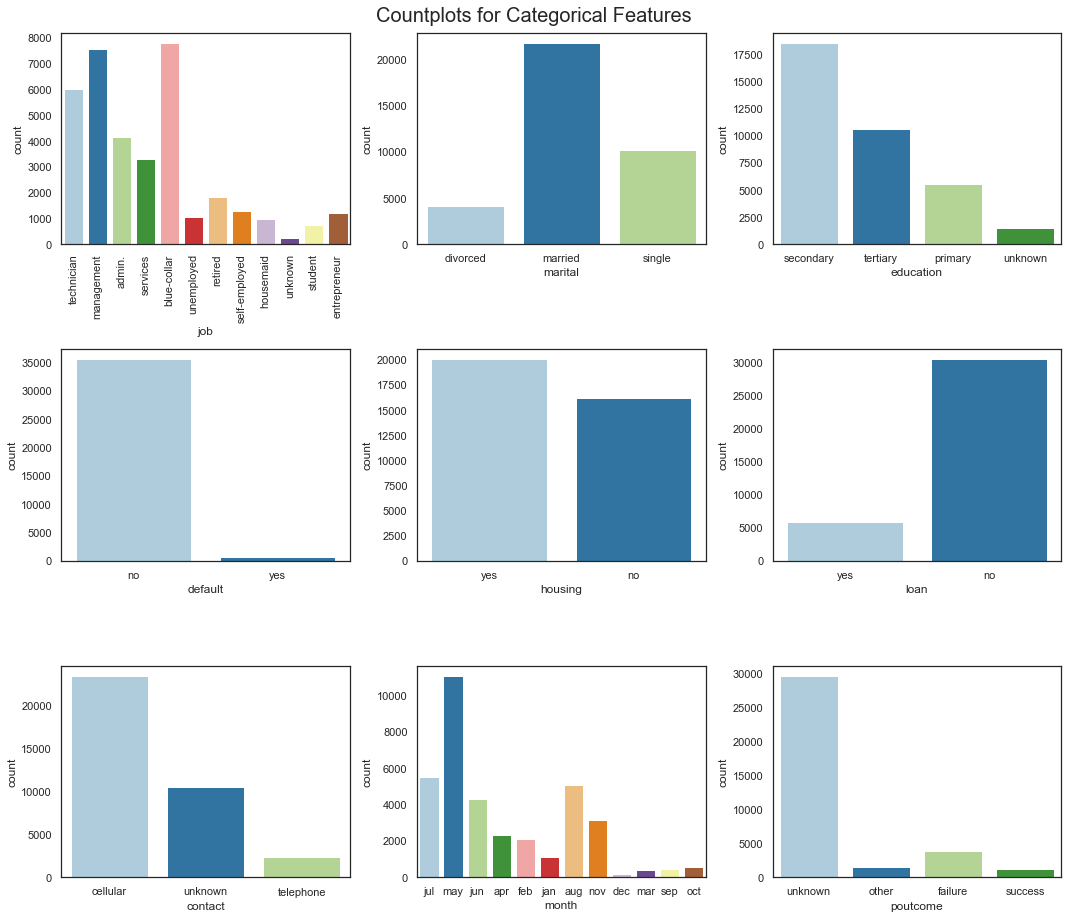

In [14]:
# categorical features
sns.set_palette('Paired')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13))
for i, ax in enumerate(axes.flat):
    sns.countplot(x=train[cat_cols[i]], ax=ax)
    if cat_cols[i] == 'job':
        ax.tick_params(axis='x', labelrotation=90)
fig.suptitle('Countplots for Categorical Features', fontsize=20)
plt.tight_layout()
#train[num_cols].hist(bins=30, figsize=(15,12))
#save_fig("cat_cols_distribution_plots")

Finally, our target variable.

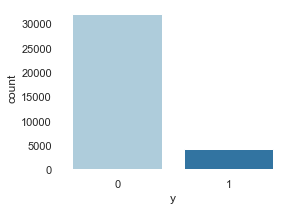

In [15]:
# target variable: very unbalanced, about 10% are positive
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=train['y'], ax=ax)
sns.despine(left=True, bottom=True);

## Correlations<a name="3.2"></a>

### What are the correlation between numerical features?

In [16]:
# check correlations between numerical features
corrT = train[num_cols + ['y']].corr()
corrT

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.093403,-0.008967,-0.003116,0.000354,-0.022179,0.001556,0.021976
balance,0.093403,1.000000,0.007385,0.022069,-0.014053,0.004141,0.017863,0.048057
day,-0.008967,0.007385,1.000000,-0.030053,0.163619,-0.091943,-0.051983,-0.030527
duration,-0.003116,0.022069,-0.030053,1.000000,-0.086969,0.000291,0.002381,0.401466
campaign,0.000354,-0.014053,0.163619,-0.086969,1.000000,-0.089526,-0.033579,-0.072407
pdays,-0.022179,0.004141,-0.091943,0.000291,-0.089526,1.000000,0.437361,0.106851
previous,0.001556,0.017863,-0.051983,0.002381,-0.033579,0.437361,1.000000,0.088729
y,0.021976,0.048057,-0.030527,0.401466,-0.072407,0.106851,0.088729,1.000000


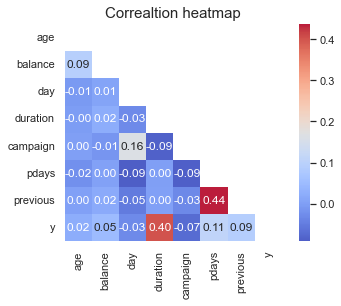

In [17]:
# heatmap of correlation
mask = np.zeros_like(corrT, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrT, annot=True, fmt = '.2f',square=True, cmap='coolwarm', mask=mask, alpha=0.9)
plt.title('Correaltion heatmap', fontsize=15);

- **duration** and target **y** are positively correlated, which is intuitive
- **previous** and **pdays** are positively correlated, this might have something to do with the campaign strategy

### How does each numerical feature correlate with target? <a name="3.3"></a>

In [18]:
pd.pivot_table(train, index='y', values=num_cols)

,age,balance,campaign,day,duration,pdays,previous
y,,,,,,,
0,40.857156,1310.864702,2.852115,15.870902,220.782196,35.878417,0.502583
1,41.583077,1774.109903,2.149374,15.081305,542.036871,68.973056,1.160955


From the looks of it, it seems like except for age and day, the rest of the features seem to have some distinguishing power over target.

Let's closely examine each numerical feature vs target variable.

### age vs y

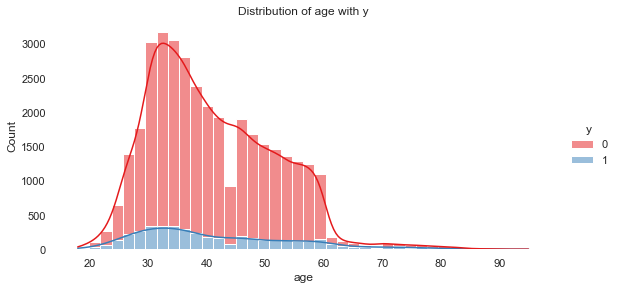

In [19]:
sns.displot(data=train, kind='hist', x='age', hue='y', bins=40, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of age with y');

In [20]:
# try discretize age into groups
min_age = train.age.min()
max_age = train.age.max()
train['age_group'] = pd.cut(train.age, bins=[min_age-1, 30, 35, 40, 45, 50, 55, 60, max_age+1])
test['age_group'] = pd.cut(test.age, bins=[min_age-1, 30, 35, 40, 45, 50, 55, 60, max_age+1])

# check out each age group's size and proportion of subscribing (y=1)
age_group = train.pivot_table(index='age_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
age_group.columns = ['age_group', 'size', 'proportion of yes']
age_group

,age_group,size,proportion of yes
0,"(17, 30]",5636,0.162881
1,"(30, 35]",7852,0.106724
2,"(35, 40]",6287,0.098934
3,"(40, 45]",4833,0.086903
4,"(45, 50]",4160,0.093029
5,"(50, 55]",3485,0.095552
6,"(55, 60]",2977,0.109506
7,"(60, 96]",938,0.412580


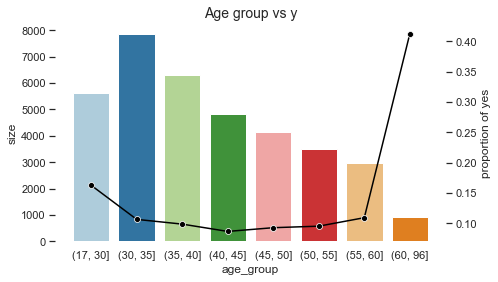

In [21]:
# visualization of age_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=age_group, x='age_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=age_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Age group vs y', fontsize=14);

**Insights**
- Interestingly, the age groups on the two extreme ends of the spectrum seem to have better chances of subscribing to the term deposit, while the age groups in the middle have relatively lower proportion of people subscribing the product. 

- Moreover, we see that as age group goes up, the size generally goes down.

- *Possible strategy suggestion: maybe we should invest more resources on the extreme ends of the spectrum, i.e. targeting people in the age group below 30 and above 55.*

### balance vs y

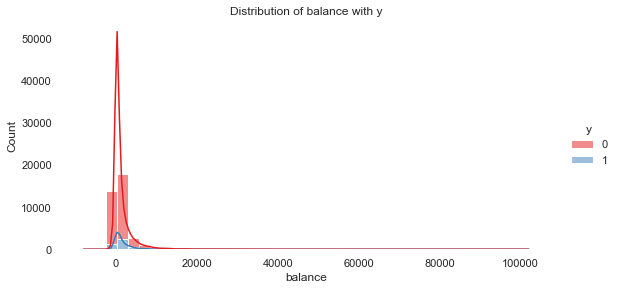

In [22]:
sns.displot(data=train, kind='hist', x='balance', hue='y', bins=40, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of balance with y');

In [23]:
# it's a bit hard to visualize the relationship between y and balance, let's try binning again
train['balance_group'] = pd.cut(train.balance, bins=[float('-inf'), 0, 100, 500, 1500, float('inf')])
balance_group = train.pivot_table(index='balance_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
balance_group.columns = ['balance_group', 'size', 'proportion of yes']
balance_group

,balance_group,size,proportion of yes
0,"(-inf, 0.0]",5805,0.068045
1,"(0.0, 100.0]",4190,0.079475
2,"(100.0, 500.0]",8936,0.114033
3,"(500.0, 1500.0]",8543,0.127005
4,"(1500.0, inf]",8694,0.160916


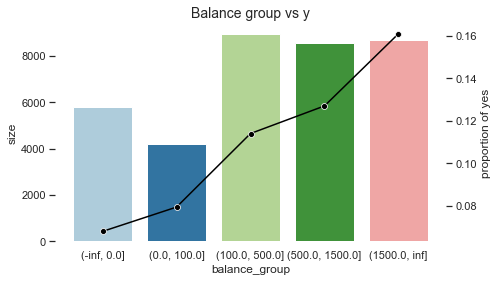

In [24]:
# visualization of balance_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=balance_group, x='balance_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=balance_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Balance group vs y', fontsize=14);

Intuitively, the more balance, the more likely to subscribe to a term deposit.

### day vs y

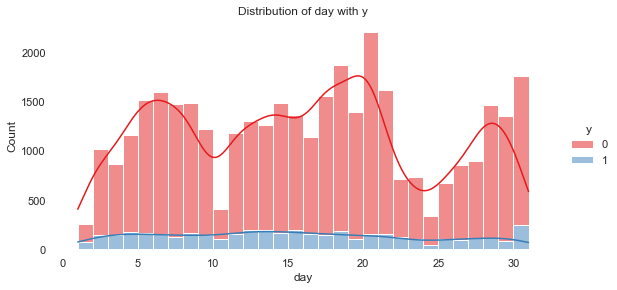

In [25]:
sns.displot(data=train, kind='hist', x='day', hue='y', bins=30, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of day with y');

### day_month vs y

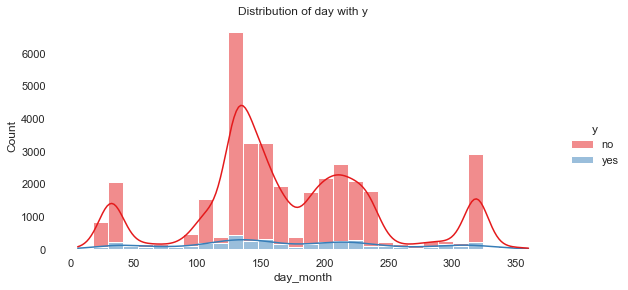

In [421]:
sns.displot(data=train, kind='hist', x='day_month', hue='y', bins=30, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of day with y');

Seems like day is not informative of target y.

### duration vs y

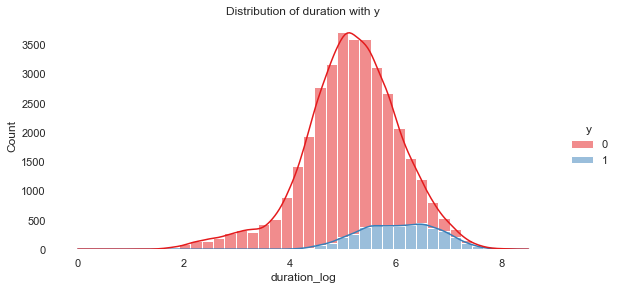

In [26]:
# duration is skewed to the right, apply np.log1p to give a more normal semblance
train['duration_log'] = train['duration'].apply(np.log1p)
sns.displot(data=train, kind='hist', x='duration_log', hue='y', bins=40, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of duration with y');

As expected, the longer duration of the last contact, the more likely to subscribe

### campaign (number of contacts) vs y

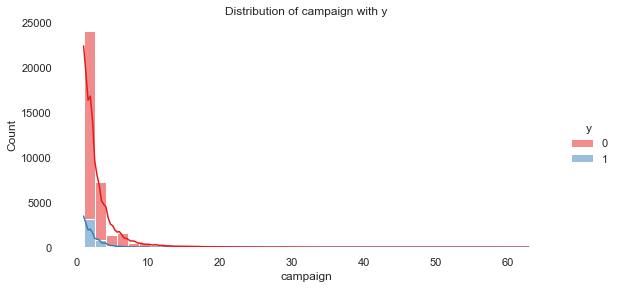

In [27]:
sns.displot(data=train, kind='hist', x='campaign', hue='y', bins=40, kde=True,
            multiple='stack', height=4, aspect=2, palette='Set1')
sns.despine(left=True, bottom=True)
plt.title('Distribution of campaign with y');

In [28]:
# histogram is a bit harder to read
# try discretize campaign to examine its relationship with y
max_campaign = train.campaign.max()
train['campaign_group'] = pd.cut(train.campaign, bins = [0, 1, 2, 3, 5, max_campaign])
campaign_group = train.pivot_table(index='campaign_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
campaign_group.columns = ['campaign_group', 'size', 'proportion of yes']
campaign_group

,campaign_group,size,proportion of yes
0,"(0, 1]",14040,0.144587
1,"(1, 2]",9990,0.112813
2,"(2, 3]",4417,0.113425
3,"(3, 5]",4233,0.089062
4,"(5, 63]",3488,0.056193


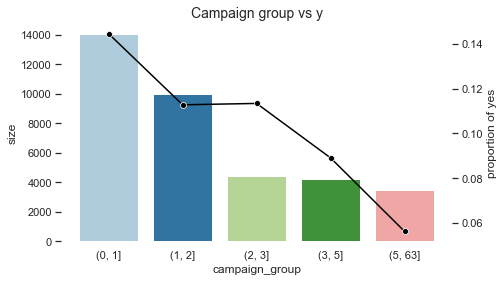

In [29]:
# visualization of campaign_group
fig, ax1 = plt.subplots(figsize=(7, 4))
sns.barplot(data=campaign_group, x='campaign_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=campaign_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('Campaign group vs y', fontsize=14);

**Insights**
- As the number of contacts goes up, the proportion of people subscribing is actually dropping. (Clients may get annoyed after multiple contacts)

- *Bussiness suggestion: Invest more on the first 3 contacts, expecially the 1st contact since it appears to have the highest chance of success; moreover, after 5 contacts, there is probably no need to keep pushing because the chance is really slim there.*

### pdays vs y

In [30]:
# pdays has -1 values and is skewed to the right, try discretization
pdays_max = train.pdays.max()  # 871
train['pdays_group'] = pd.cut(train.pdays, bins = [-1, 0, 30, 120, 180, 210, 390, float('inf')], include_lowest=True, right=False)
test['pdays_group'] = pd.cut(test.pdays, bins = [-1, 0, 30, 120, 180, 210, 390, float('inf')], include_lowest=True, right=False)
pdays_group = train.pivot_table(index='pdays_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
pdays_group.columns = ['pdays_group', 'size', 'proportion of yes']
pdays_group

,pdays_group,size,proportion of yes
0,"[-1.0, 0.0)",29619,0.091563
1,"[0.0, 30.0)",141,0.134752
2,"[30.0, 120.0)",1363,0.402054
3,"[120.0, 180.0)",1015,0.152709
4,"[180.0, 210.0)",1024,0.368164
5,"[210.0, 390.0)",2797,0.113336
6,"[390.0, inf)",209,0.492823


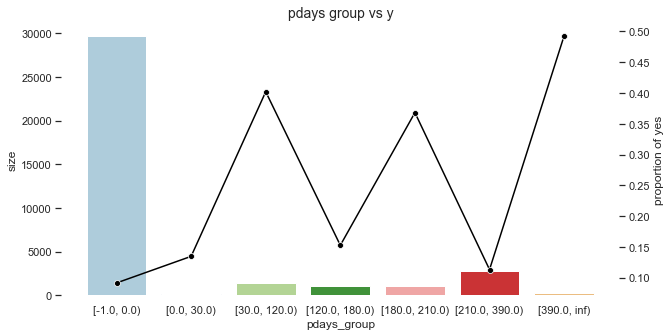

In [31]:
# visualization of pdays
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=pdays_group, x='pdays_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=pdays_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('pdays group vs y', fontsize=14);

Some interesting pattern here, maybe this zigzag pattern has something to do with the term of deposits. Consider using the binning feature in modeling.

Moreover, the proportion of y = 1 is the lowest for clients who have not been previously contacted.

### previous vs y

In [32]:
# previous is similar to campaign, but for previous contacts
train['previous_group'] = pd.cut(train.previous, bins = [0, 1, 2, 3, 5, float('inf')], include_lowest=True, right=False)
previous_group = train.pivot_table(index='previous_group', values='y', aggfunc=[np.size, np.mean]).reset_index()
previous_group.columns = ['previous_group', 'size', 'proportion of yes']
previous_group

,previous_group,size,proportion of yes
0,"[0.0, 1.0)",29619,0.091563
1,"[1.0, 2.0)",2197,0.213928
2,"[2.0, 3.0)",1671,0.214841
3,"[3.0, 5.0)",1458,0.255830
4,"[5.0, inf)",1223,0.259199


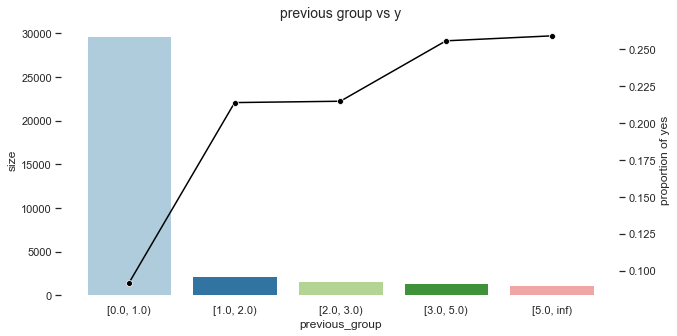

In [33]:
# visualization of previous contacts
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=previous_group, x='previous_group', y='size', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=previous_group['proportion of yes'], marker='o', color='black', sort = False, ax=ax2)
sns.despine(left=True, bottom=True)
plt.title('previous group vs y', fontsize=14);

Somehow in contrast to the campaign group!

- as number of contacts in current campaign goes up, the proportion goes down.

- as the number of contacts in previous campagn goes up, the proportion actually goes up.

### How does each categorical feature correlate with our target? <a name="3.4"></a>

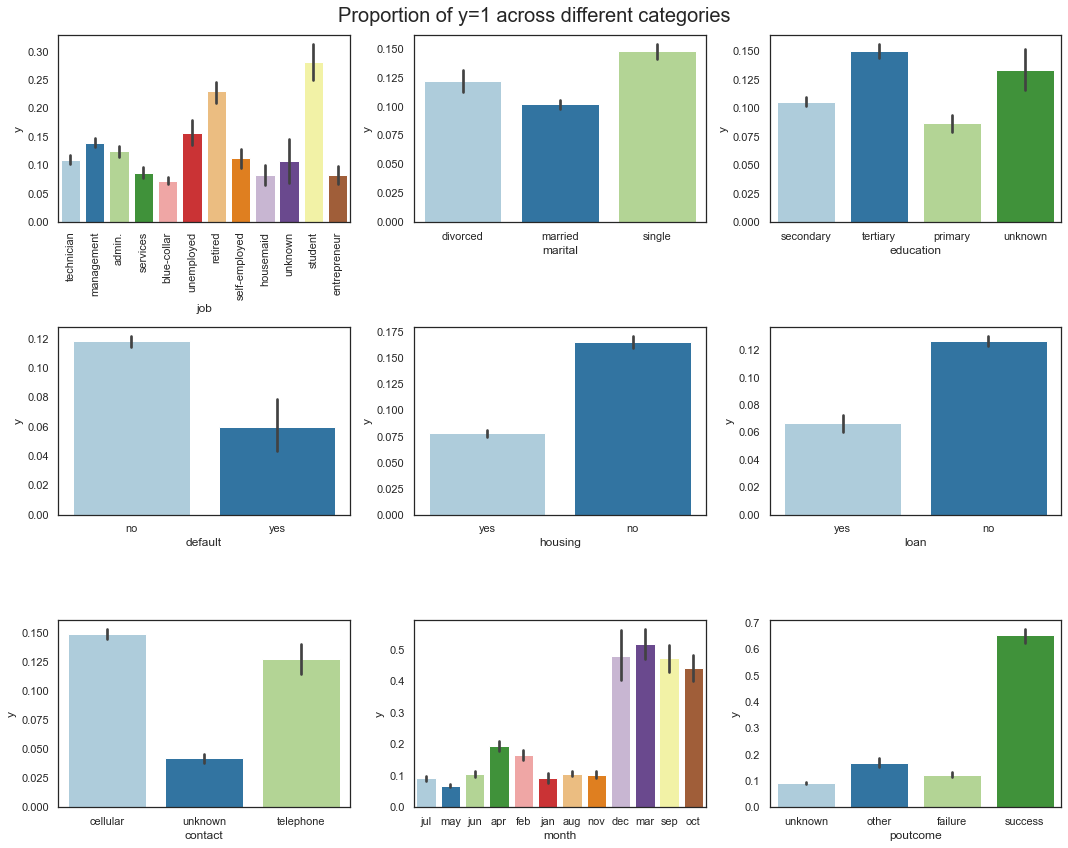

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    g = sns.barplot(data=train, x=cat_cols[i], y='y', ax=ax, palette='Paired')
    if cat_cols[i] == 'job':
        ax.tick_params(axis='x', labelrotation=90)
plt.suptitle('Proportion of y=1 across different categories', fontsize=20)
plt.tight_layout()

### Experimenting attribute combinations <a name='3.5'></a>

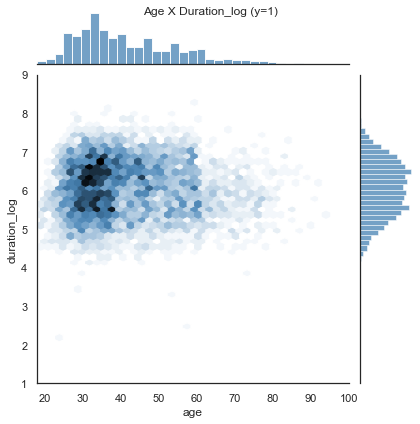

In [35]:
# age x Duration
sns.jointplot(data=train[train['y'] == 1], x='age', y='duration_log', kind='hex',
              xlim=(18, 100), ylim=(1, 9), color='steelblue')
plt.suptitle('Age X Duration_log (y=1)', fontsize=12);

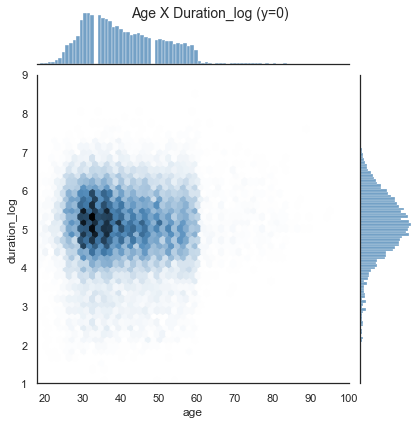

In [36]:
# age x Duration
sns.jointplot(data=train[train['y'] == 0], x='age', y='duration_log', 
              kind='hex', xlim=(18, 100), ylim=(1, 9), color='steelblue')
plt.suptitle('Age X Duration_log (y=0)', fontsize=14);

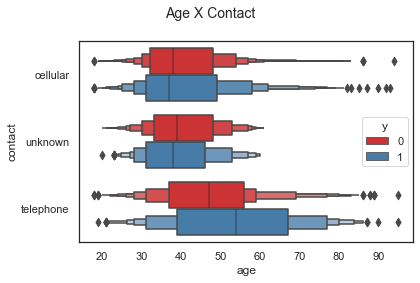

In [37]:
# Age x Contact
sns.boxenplot(data=train, x='age', y='contact', hue='y', palette='Set1')
plt.suptitle('Age X Contact', fontsize=14)
plt.tight_layout();

In [38]:
train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_log', 'duration_log',
       'campaign_log', 'pdays_log', 'age_group', 'balance_group',
       'campaign_group', 'pdays_group', 'previous_group'],
      dtype='object')

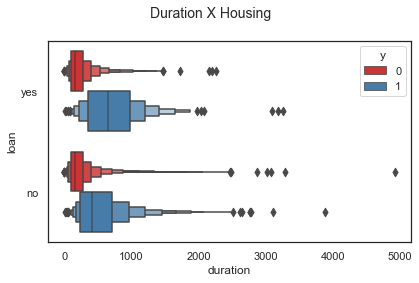

In [39]:
# Duration x Housing
sns.boxenplot(data=train, x='duration', y='loan', hue='y', palette='Set1')
plt.suptitle('Duration X Housing', fontsize=14)
plt.tight_layout();

<a name="4"></a>
# 4 - Preprocessing

In [50]:
# preprocessor and pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [51]:
train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_log', 'duration_log',
       'campaign_log', 'pdays_log', 'age_group', 'balance_group',
       'campaign_group', 'pdays_group', 'previous_group'],
      dtype='object')

In [52]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_group', 'age_group']
num_cols = ['balance', 'duration', 'campaign', 'previous', 'day']  # 'pdays', 'age'

In [86]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_cols = ['balance', 'age', 'pdays', 'day', 'duration', 'campaign', 'previous']


In [87]:
X_train = train[cat_cols + num_cols]
y_train = train.y
X_test = test[cat_cols + num_cols]
y_test = test.y

In [88]:
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)

In [89]:
X_train_prepared

<36168x48 sparse matrix of type '<class 'numpy.float64'>'
	with 496634 stored elements in Compressed Sparse Row format>

In [90]:
X_test_prepared = preprocessor.transform(X_test)

# 5 - Dimensionality reduction and visualization <a name='5'></a>

Since our data are in high-dimensional space, let us utilize some dimensionality reduction algorithms to visualize the datasets.

In [48]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [51]:
np.random.seed(42)
X_reduced_tsne = TSNE(n_components=2).fit_transform(X_train_prepared)
X_reduced_pca = PCA(n_components=4).fit_transform(X_train_prepared.toarray())
X_reduced_svd = TruncatedSVD(n_components=2).fit_transform(X_train_prepared)

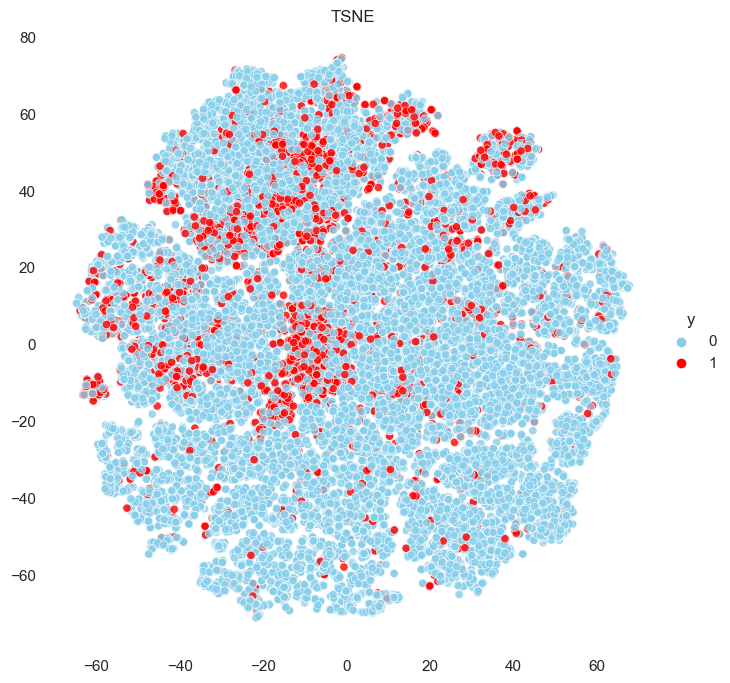

In [49]:
sns.relplot(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], hue=y_train, kind='scatter', 
            palette={0:'skyblue', 1:'red'}, height=7, alpha=0.8)
plt.title('TSNE')
plt.xlabel('')
plt.ylabel('')
plt.box(False);

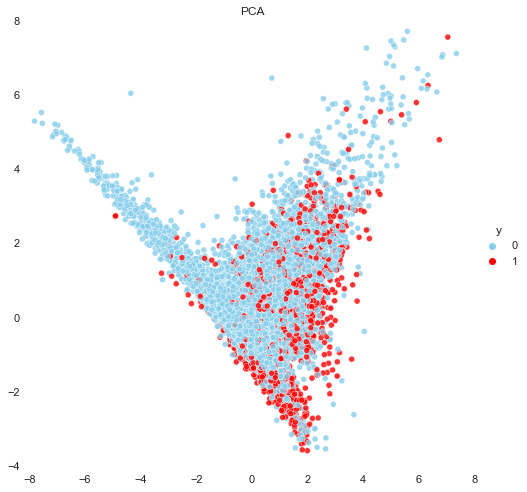

In [50]:
sns.relplot(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], hue=y_train, kind='scatter',
            palette={0:'skyblue', 1:'red'}, height=7, alpha=0.8)
plt.title('PCA')
plt.xlabel('')
plt.ylabel('')
plt.xlim(-8, 8)
plt.ylim(-4, 8)
plt.box(False);

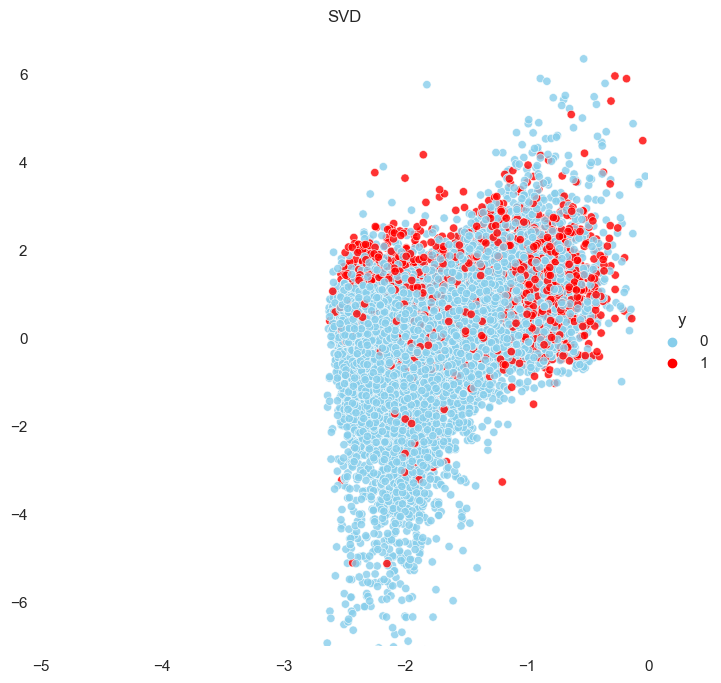

In [138]:
sns.relplot(x=X_reduced_svd[:,0], y=X_reduced_svd[:,1], hue=y_train, kind='scatter',
           palette={0:'skyblue', 1:'red'}, height=7, alpha=0.8)
plt.title('SVD')
plt.xlabel('')
plt.ylabel('')
plt.xlim(-5, 0)
plt.ylim(-7, 7)
plt.box(False);

From the visualization, it seems hard to separate the 2 classes.

<a name="6"></a>
# 6 - Modeling

The goal is to identify who are more likely to subscribe. But there is always a tradeoff between precision and recall. On the one hand, we want to maximize our recall so that we can identify as many successful potentials as possible. On the other hand, we would want to a relatively high precision so that the bank will not waste valuable resources on someone who may never subscribe. 

Therefore, the primary metric will be `recall` and `precision` of the positive class, with `F1-score` being kind of balance of the two. And we think this task is more recall-oriented, in that false negatives miss out actual buyers and lose out valuable business opportunities, whereas false positives (a client is incorrectly flagged as potential buyer) cost nothing more than a few contact attempts.

This is why later we will tune the models for higher recall.

In [47]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## baseline models <a name='6.1'></a>

Here just quickly try a few of baseline models with default parameters, also we are using all of the features.

### logistic regression

In [48]:
lr = LogisticRegression(max_iter=500, class_weight='balanced')
print('logistic regression')

lr_scores = cross_val_score(lr, X_train_prepared, y_train, scoring='f1', cv=5)
print(f'f1: {lr_scores.mean():.2f}')

lr_scores = cross_val_score(lr, X_train_prepared, y_train, scoring='recall', cv=5)
print(f'recall: {lr_scores.mean():.2f}')

logistic regression
f1: 0.56
recall: 0.82


### svm

In [49]:
svc = SVC(class_weight='balanced')
print('svm')

svc_scores = cross_val_score(svc, X_train_prepared, y_train, scoring='f1', cv=5)
print(f'f1: {svc_scores.mean():.2f}')

svc_scores = cross_val_score(lr, X_train_prepared, y_train, scoring='recall', cv=5)
print(f'recall: {svc_scores.mean():.2f}')

svm
f1: 0.58
recall: 0.82


### adaboost

In [ ]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
print('adaboost')

ada_scores = cross_val_score(ada, X_train_prepared, y_train, scoring='f1', cv=5)
print(f'f1: {ada_scores.mean():.2f}')

ada_scores = cross_val_score(ada, X_train_prepared, y_train, scoring='recall', cv=5)
print(f'recall: {ada_scores.mean():.2f}')

### gradient boosting trees

In [ ]:
gbt = GradientBoostingClassifier()
print('GBDT')

# tweak sample weights a little bit
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 1] = weight_for_1
sample_weights[y_train == 0] = weight_for_0

gbt.fit(X_train_prepared, y_train, sample_weight=sample_weights)
y_test_pred = gbt.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

### xgb

In [101]:
neg_to_pos_ratio = round(sum(y_train==0) / sum(y_train==1), 2)
print('neg to pos ratio:', neg_to_pos_ratio)

neg to pos ratio: 7.55


In [102]:
xgb = XGBClassifier(eval_metric='logloss', 
                    use_label_encoder=False, 
                    scale_pos_weight=neg_to_pos_ratio)
print('xgboost')

xgb_scores = cross_val_score(xgb, X_train_prepared, y_train, scoring='f1', cv=5)
print(f'f1: {xgb_scores.mean():.2f}')

xgb_scores = cross_val_score(xgb, X_train_prepared, y_train, scoring='recall', cv=5)
print(f'recall: {xgb_scores.mean():.2f}')

xgboost
f1: 0.61
recall: 0.80


In [50]:
xgb.fit(X_train_prepared, y_train)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      7985
           1       0.48      0.82      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.73      0.85      0.76      9043
weighted avg       0.92      0.87      0.89      9043

[[7044  941]
 [ 193  865]]


>**Note**: we can actually reach a recall of 0.9 if we keep increasing the weight of positive classes, but the precision will be sufficiently lower than 0.5, therefore decreasing overall f1-score. This tradeoff needs to be considered with bussiness interest and application.

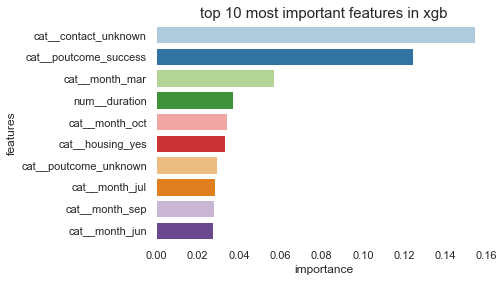

In [51]:
feature_importance = pd.DataFrame({'features': preprocessor.get_feature_names_out(X_train.columns), 
                                   'importance': xgb.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
sns.barplot(data=feature_importance[:10], y='features', x='importance')
sns.despine(left=True, bottom=True)
plt.title('top 10 most important features in xgb', fontsize=15);

## Imputing education data based on job
    admin. -> secondary
    management -> tertiary
    services -> secondary
    blue-collar -> primary, secondary
    housemaid -> primary, secondary
    self-employed -> secondary, tertiary
    technician -> secondary, tertiary
    entrepreneur -> secondary, tertiary


not clear: retired, student, unemployed, unknown

In [269]:
train.loc[(train['job'] == 'admin.')&(train['education'] == 'unknown'), 'education'] = 'secondary'
test.loc[(test['job'] == 'admin.')&(test['education'] == 'unknown'), 'education'] = 'secondary'
train.loc[(train['job'] == 'management')&(train['education'] == 'unknown'), 'education'] = 'tertiary'
test.loc[(test['job'] == 'management')&(test['education'] == 'unknown'), 'education'] = 'tertiary'
train.loc[(train['job'] == 'services')&(train['education'] == 'unknown'),'education' ] = 'secondary'
test.loc[(test['job'] == 'services')&(test['education'] == 'unknown'),'education' ] = 'secondary'
train.loc[(train['job'] == 'blue-collar')&(train['education'] == 'unknown'),'education' ] = 'secondary'
test.loc[(test['job'] == 'blue-collar')&(test['education'] == 'unknown'),'education' ] = 'secondary'
train.loc[(train['job'] == 'housemaid')&(train['education'] == 'unknown'),'education' ] = 'primary'
test.loc[(test['job'] == 'housemaid')&(test['education'] == 'unknown'),'education' ] = 'primary'
train.loc[(train['job'] == 'self-employed')&(train['education'] == 'unknown'),'education' ] = 'tertiary'
test.loc[(test['job'] == 'self-employed')&(test['education'] == 'unknown'),'education' ] = 'tertiary'
train.loc[(train['job'] == 'technician')&(train['education'] == 'unknown'),'education' ] = 'secondary'
test.loc[(test['job'] == 'technician')&(test['education'] == 'unknown'),'education' ] = 'secondary'
train.loc[(train['job'] == 'entrepreneur')&(train['education'] == 'unknown'),'education' ] = 'tertiary'
test.loc[(test['job'] == 'entrepreneur')&(test['education'] == 'unknown'),'education' ] = 'tertiary'

## Merge Day and month

In [414]:
def monthToNum(shortMonth):
    return {
            'jan': 1,
            'feb': 2,
            'mar': 3,
            'apr': 4,
            'may': 5,
            'jun': 6,
            'jul': 7,
            'aug': 8,
            'sep': 9, 
            'oct': 10,
            'nov': 11,
            'dec': 12
    }[shortMonth]

In [415]:
train['num_month'] = train['month'].apply(lambda x: monthToNum(x))
test['num_month'] = test['month'].apply(lambda x: monthToNum(x))

In [416]:
train['day_month'] = train["day"] +  (train["num_month"]-1)*30
test['day_month'] = test["day"] + (test["num_month"]-1)*30

In [417]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','pdays_group','previous_group']
num_cols = ['age','balance_log', 'duration_log', 'campaign', 'day_month']

X_train = train[cat_cols + num_cols]
y_train = train.y
X_test = test[cat_cols + num_cols]
y_test = test.y

preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)

X_test_prepared = preprocessor.transform(X_test)

### LGBM

In [147]:
from sklearn import metrics as met


def custom_loss_func(y_actual, y_pred):
    cm = met.confusion_matrix(y_actual, y_pred).ravel().tolist()
    precision = (cm[3])/(cm[3]+cm[1])
    recall = (cm[3])/(cm[3]+cm[2])
    f1score = 2*(precision*recall/(precision+recall))
    return recall


custom_scorer = met.make_scorer(custom_loss_func, greater_is_better=True)

In [418]:
import lightgbm as lgb
params = {
    #'num_class' : 3, # used for multi-classes
    'subsample_for_bin': 2000, # number of samples for constructing bins
    'min_split_gain': 0.4, # minimum loss reduction required to make further partition on a leaf node of the tree
}
gridParams = {
    'learning_rate': [0.02],
    'num_leaves': [16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'num_iterations': [1100],
    'boosting_type' : ['gbdt'], # for better accuracy -> try dart
    'max_bin':[255], # large max_bin helps improve accuracy but might slow down training progress
    'colsample_bytree' : [0.65],
    'subsample' : [0.65],
    'reg_alpha' : [0.5],
    'reg_lambda' : [3],
    'max_depth' : [9],
    'scale_pos_weight': [18],
    'min_child_weight': [0.02],
    'min_child_samples': [25]
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          subsample_for_bin = params['subsample_for_bin'],
          min_split_gain = params['min_split_gain'],) 



grid = GridSearchCV(mdl, gridParams, verbose=1, cv=2, n_jobs=-1, scoring=custom_scorer)
# Run the grid
grid.fit(X_train_prepared, y_train)


print(grid.best_params_)
print(grid.best_score_)


params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate'] 
params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
params['max_depth'] = grid.best_params_['max_depth']
params['scale_pos_weight'] = grid.best_params_['scale_pos_weight']
params['num_iterations'] = grid.best_params_['num_iterations']
params['min_child_weight'] = grid.best_params_['min_child_weight']
params['min_child_samples'] = grid.best_params_['min_child_samples']

Fitting 2 folds for each of 1 candidates, totalling 2 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.02, 'max_bin': 255, 'max_depth': 9, 'min_child_samples': 25, 'min_child_weight': 0.02, 'num_iterations': 1100, 'num_leaves': 16, 'reg_alpha': 0.5, 'reg_lambda': 3, 'scale_pos_weight': 18, 'subsample': 0.65}
0.9286212891087604


In [419]:
final_mdl = lgb.LGBMClassifier(**params, 
          objective = 'binary',   
          n_jobs = 5, 
          verbose = -1,
         )

final_mdl.fit(X_train_prepared, y_train)


y_test_pred = final_mdl.predict(X_test_prepared)

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

          no       0.99      0.80      0.89      7985
         yes       0.39      0.95      0.55      1058

    accuracy                           0.82      9043
   macro avg       0.69      0.87      0.72      9043
weighted avg       0.92      0.82      0.85      9043

[[6400 1585]
 [  55 1003]]


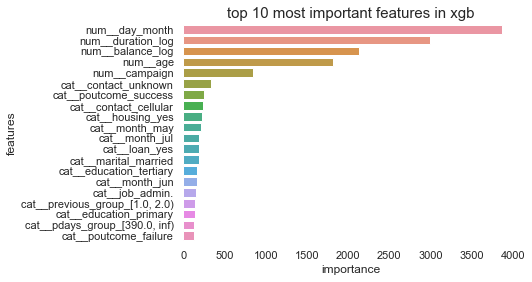

In [420]:
feature_importance = pd.DataFrame({'features': preprocessor.get_feature_names_out(X_train.columns), 
                                   'importance': final_mdl.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
sns.barplot(data=feature_importance[:20], y='features', x='importance')
sns.despine(left=True, bottom=True)
plt.title('top 10 most important features in xgb', fontsize=15);

### neural network

In [61]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model

In [62]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc', curve='roc'),  # area under the roc curve
      keras.metrics.AUC(name='prc', curve='PR')  # area under precision-recall curve
]

def build_model(num_features, metrics=METRICS, output_bias=None):
    
    # use output_bias to set initial bias to log of the odds
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    inputs = tfl.Input(shape=(num_features,))
    A1 = tfl.Dense(units=16, activation='relu')(inputs)
    D1 = tfl.Dropout(0.2)(A1)
    A2 = tfl.Dense(units=32, activation='relu')(D1)
    outputs = tfl.Dense(units=1, activation='sigmoid', bias_initializer=output_bias)(A2)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

Metal device set to: Apple M2


2022-09-23 21:21:51.551585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-23 21:21:51.551876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [1]:
train_features = X_train_prepared.toarray()
train_labels = np.array(y_train)
test_features = X_test_prepared.toarray()
test_labels = np.array(y_test)

# some setting for training
EPOCHS = 100
BATCH_SIZE = 2048  # larger batch size to compensate for imbalanced class
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


baseline_model = build_model(
    num_features=X_train_prepared.shape[-1],
    output_bias=np.log(pos/neg))

baseline_model.summary()

NameError: name 'X_train_prepared' is not defined

In [64]:
baseline_history = baseline_model.fit(
    train_features, 
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS*2,
    callbacks=[early_stopping],
    validation_data=(test_features, test_labels))

Epoch 1/200


2022-09-23 21:21:51.713987: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-23 21:21:52.494746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 0.3676 - tp: 4.0000 - fp: 15.0000 - tn: 31922.0000 - fn: 4227.0000 - accuracy: 0.8827 - precision: 0.2105 - recall: 9.4540e-04 - auc: 0.4981 - prc: 0.1136

2022-09-23 21:21:53.468291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 53ms/step - loss: 0.3676 - tp: 4.0000 - fp: 15.0000 - tn: 31922.0000 - fn: 4227.0000 - accuracy: 0.8827 - precision: 0.2105 - recall: 9.4540e-04 - auc: 0.4981 - prc: 0.1136 - val_loss: 0.3506 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7985.0000 - val_fn: 1058.0000 - val_accuracy: 0.8830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6497 - val_prc: 0.1902
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3443 - tp: 1.0000 - fp: 8.0000 - tn: 31929.0000 - fn: 4230.0000 - accuracy: 0.8828 - precision: 0.1111 - recall: 2.3635e-04 - auc: 0.6886 - prc: 0.1981 - val_loss: 0.3291 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7985.0000 - val_fn: 1058.0000 - val_accuracy: 0.8830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7856 - val_prc: 0.3124
Epoch 3/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3210 - tp: 8.0000 - fp: 26.0000 - tn: 31911.0000 - fn

18/18 [==============================] - 0s 17ms/step - loss: 0.2108 - tp: 1676.0000 - fp: 857.0000 - tn: 31080.0000 - fn: 2555.0000 - accuracy: 0.9057 - precision: 0.6617 - recall: 0.3961 - auc: 0.9215 - prc: 0.5934 - val_loss: 0.2149 - val_tp: 418.0000 - val_fp: 224.0000 - val_tn: 7761.0000 - val_fn: 640.0000 - val_accuracy: 0.9045 - val_precision: 0.6511 - val_recall: 0.3951 - val_auc: 0.9196 - val_prc: 0.5577
Epoch 40/200
18/18 [==============================] - 0s 15ms/step - loss: 0.2104 - tp: 1707.0000 - fp: 899.0000 - tn: 31038.0000 - fn: 2524.0000 - accuracy: 0.9054 - precision: 0.6550 - recall: 0.4035 - auc: 0.9219 - prc: 0.5932 - val_loss: 0.2150 - val_tp: 390.0000 - val_fp: 207.0000 - val_tn: 7778.0000 - val_fn: 668.0000 - val_accuracy: 0.9032 - val_precision: 0.6533 - val_recall: 0.3686 - val_auc: 0.9194 - val_prc: 0.5586
Epoch 41/200
18/18 [==============================] - 0s 16ms/step - loss: 0.2095 - tp: 1738.0000 - fp: 900.0000 - tn: 31037.0000 - fn: 2493.0000 - accur

18/18 [==============================] - 0s 16ms/step - loss: 0.2009 - tp: 1974.0000 - fp: 984.0000 - tn: 30953.0000 - fn: 2257.0000 - accuracy: 0.9104 - precision: 0.6673 - recall: 0.4666 - auc: 0.9295 - prc: 0.6256 - val_loss: 0.2075 - val_tp: 482.0000 - val_fp: 298.0000 - val_tn: 7687.0000 - val_fn: 576.0000 - val_accuracy: 0.9034 - val_precision: 0.6179 - val_recall: 0.4556 - val_auc: 0.9251 - val_prc: 0.5834
Epoch 78/200
18/18 [==============================] - 0s 16ms/step - loss: 0.1999 - tp: 2018.0000 - fp: 1061.0000 - tn: 30876.0000 - fn: 2213.0000 - accuracy: 0.9095 - precision: 0.6554 - recall: 0.4770 - auc: 0.9302 - prc: 0.6259 - val_loss: 0.2075 - val_tp: 450.0000 - val_fp: 269.0000 - val_tn: 7716.0000 - val_fn: 608.0000 - val_accuracy: 0.9030 - val_precision: 0.6259 - val_recall: 0.4253 - val_auc: 0.9255 - val_prc: 0.5872
Epoch 79/200
18/18 [==============================] - 0s 16ms/step - loss: 0.1999 - tp: 2002.0000 - fp: 996.0000 - tn: 30941.0000 - fn: 2229.0000 - accu

18/18 [==============================] - 0s 18ms/step - loss: 0.1945 - tp: 2270.0000 - fp: 1189.0000 - tn: 30748.0000 - fn: 1961.0000 - accuracy: 0.9129 - precision: 0.6563 - recall: 0.5365 - auc: 0.9346 - prc: 0.6417 - val_loss: 0.2037 - val_tp: 532.0000 - val_fp: 329.0000 - val_tn: 7656.0000 - val_fn: 526.0000 - val_accuracy: 0.9055 - val_precision: 0.6179 - val_recall: 0.5028 - val_auc: 0.9280 - val_prc: 0.5961
Epoch 116/200
18/18 [==============================] - 0s 16ms/step - loss: 0.1941 - tp: 2279.0000 - fp: 1196.0000 - tn: 30741.0000 - fn: 1952.0000 - accuracy: 0.9130 - precision: 0.6558 - recall: 0.5386 - auc: 0.9349 - prc: 0.6441 - val_loss: 0.2037 - val_tp: 538.0000 - val_fp: 337.0000 - val_tn: 7648.0000 - val_fn: 520.0000 - val_accuracy: 0.9052 - val_precision: 0.6149 - val_recall: 0.5085 - val_auc: 0.9282 - val_prc: 0.5960
Epoch 117/200
18/18 [==============================] - 0s 16ms/step - loss: 0.1951 - tp: 2317.0000 - fp: 1190.0000 - tn: 30747.0000 - fn: 1914.0000 - 

Epoch 134/200
18/18 [==============================] - 0s 17ms/step - loss: 0.1922 - tp: 2333.0000 - fp: 1190.0000 - tn: 30747.0000 - fn: 1898.0000 - accuracy: 0.9146 - precision: 0.6622 - recall: 0.5514 - auc: 0.9366 - prc: 0.6492 - val_loss: 0.2025 - val_tp: 556.0000 - val_fp: 365.0000 - val_tn: 7620.0000 - val_fn: 502.0000 - val_accuracy: 0.9041 - val_precision: 0.6037 - val_recall: 0.5255 - val_auc: 0.9290 - val_prc: 0.5984
Epoch 135/200
18/18 [==============================] - 0s 17ms/step - loss: 0.1931 - tp: 2406.0000 - fp: 1240.0000 - tn: 30697.0000 - fn: 1825.0000 - accuracy: 0.9153 - precision: 0.6599 - recall: 0.5687 - auc: 0.9355 - prc: 0.6488 - val_loss: 0.2024 - val_tp: 542.0000 - val_fp: 348.0000 - val_tn: 7637.0000 - val_fn: 516.0000 - val_accuracy: 0.9045 - val_precision: 0.6090 - val_recall: 0.5123 - val_auc: 0.9292 - val_prc: 0.5979
Epoch 136/200
18/18 [==============================] - 0s 17ms/step - loss: 0.1925 - tp: 2384.0000 - fp: 1220.0000 - tn: 30717.0000 - fn

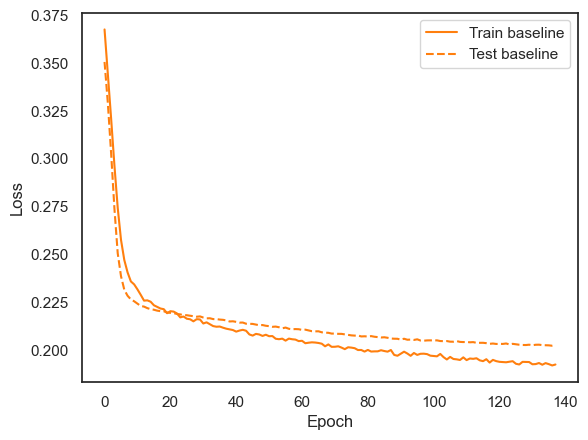

In [65]:
plot_loss(baseline_history, 'baseline', 1)

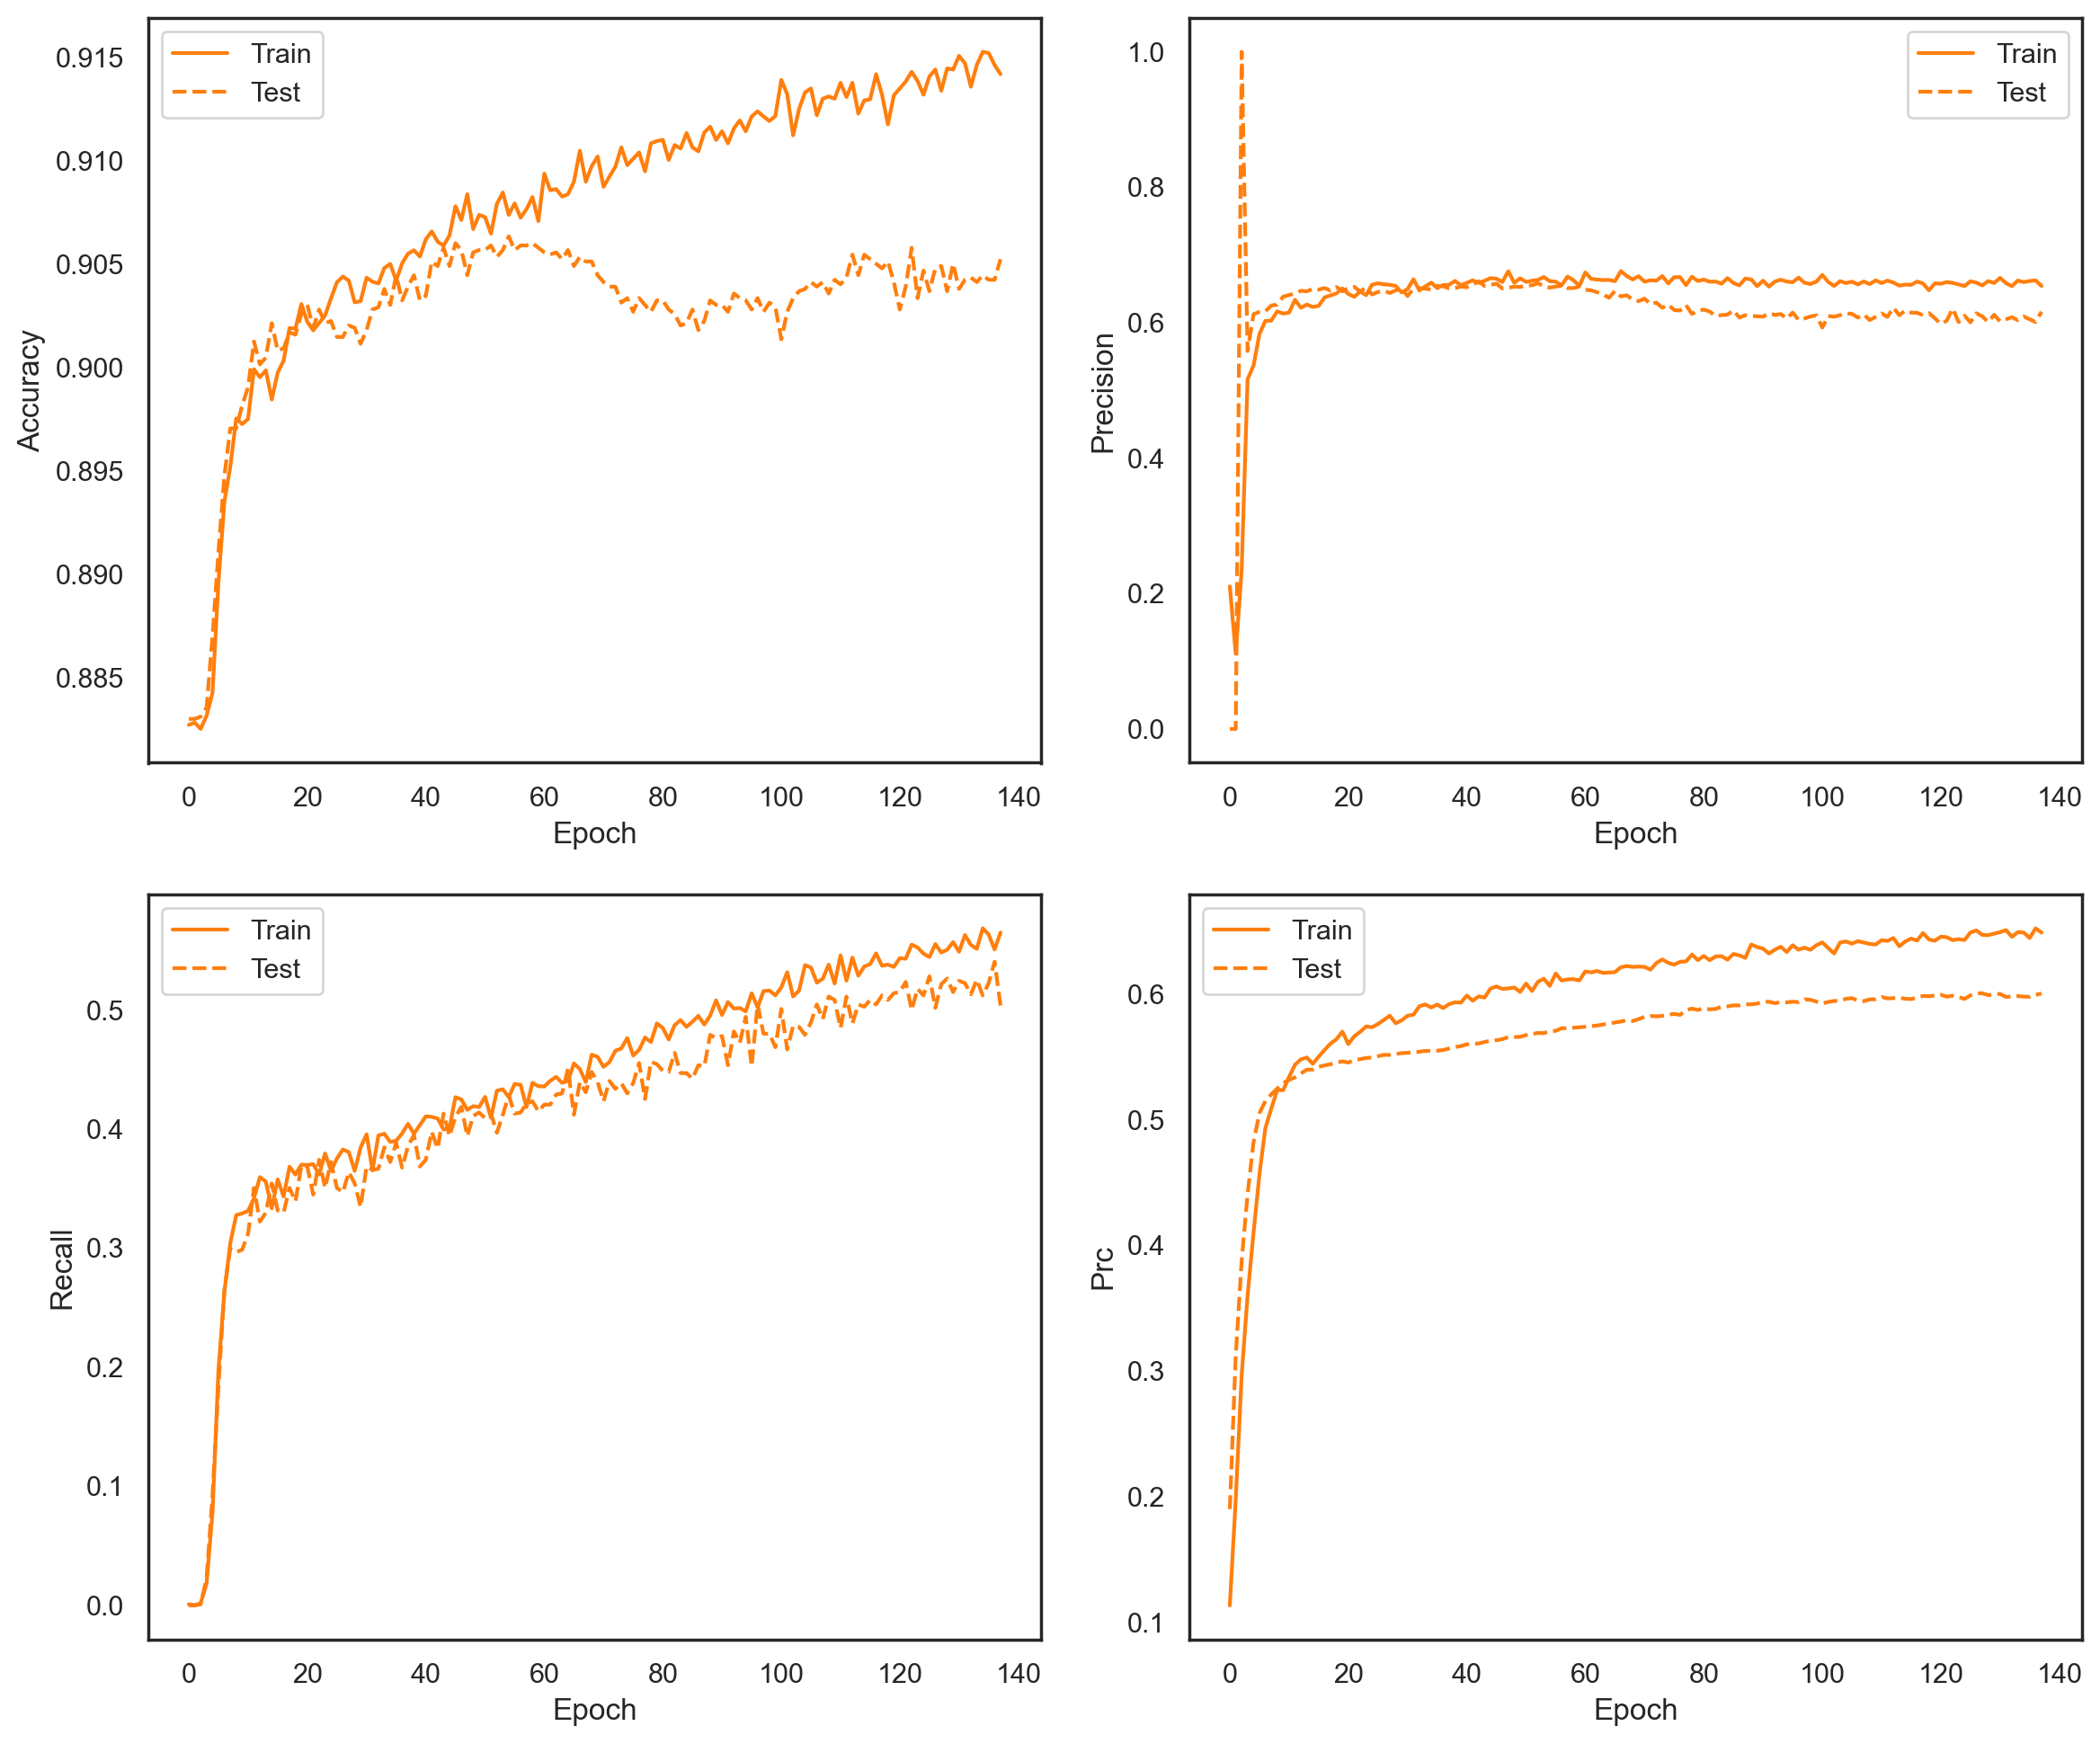

In [66]:
plot_metrics(baseline_history)

In [67]:
baseline_results = baseline_model.evaluate(X_test_prepared.toarray(), 
                                  y_test,
                                  batch_size=BATCH_SIZE, 
                                  verbose=0)
print('Evaluation of baseline nn model')
for name, value in zip(baseline_model.metrics_names, baseline_results):
    print(name, ':', value)

2022-09-23 21:22:35.815879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Evaluation of baseline nn model
loss : 0.20256517827510834
tp : 552.0
fp : 354.0
tn : 7631.0
fn : 506.0
accuracy : 0.9048988223075867
precision : 0.6092715263366699
recall : 0.52173912525177
auc : 0.928935170173645
prc : 0.600615382194519


In [68]:
baseline_train_pred = baseline_model.predict(X_train_prepared.toarray())
baseline_test_pred = baseline_model.predict(X_test_prepared.toarray())

  94/1131 [=>............................] - ETA: 1s

2022-09-23 21:22:36.619459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


283/283 [==============================] - 0s 1ms/step


## Hyperparameter tuning <a name='6.2'></a>

As specified earlier, here we will tune for higher recall.

In [69]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### svm

In [71]:
param_grid = {'kernel': ['rbf', 'linear'],
              'gamma': [0.1],
              'C': [1]}

svm_gs = GridSearchCV(
    estimator=SVC(class_weight='balanced'),
    param_grid=param_grid, 
    scoring='recall', 
    cv=3)

svm_gs.fit(X_train_prepared, y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1], 'gamma': [0.1], 'kernel': ['rbf', 'linear']},
             scoring='recall')

In [72]:
svm_gs.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [73]:
y_test_pred = svm_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7985
           1       0.43      0.86      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6802 1183]
 [ 148  910]]


### adaboost

In [74]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400], 
              'learning_rate': np.logspace(-2, 0, num=10),
              'base_estimator__max_features': ['sqrt', 'log2', None]}

ada_gs = GridSearchCV(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced')),
    param_grid=param_grid, 
    scoring='recall', 
    n_jobs=-1, 
    cv=3)

ada_gs.fit(X_train_prepared, y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_depth=1)),
             n_jobs=-1,
             param_grid={'base_estimator__max_features': ['sqrt', 'log2', None],
                         'learning_rate': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='recall')

In [75]:
ada_gs.best_params_

{'base_estimator__max_features': None,
 'learning_rate': 0.5994842503189409,
 'n_estimators': 50}

In [76]:
y_test_pred = ada_gs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7985
           1       0.41      0.83      0.55      1058

    accuracy                           0.84      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.91      0.84      0.86      9043

[[6716 1269]
 [ 181  877]]


### xgboost

In [58]:
# randomized search
param_grid = {'n_estimators': [100, 200, 300], 
              'max_leaves': [16, 20, 24, 28],
              'learning_rate': [0.01, 0.03, 0.05, 0.1],
              'scale_pos_weight': [8, 16, 32, 64],
              'gamma': np.logspace(-2, -1, 5),
              'min_child_weight': np.logspace(-2, -1, 5),
              'reg_lambda': [0.1, 0.3, 1]}

xgb_rs = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    param_distributions=param_grid,
    scoring='recall', 
    cv=3, 
    n_iter=20)

xgb_rs.fit(X_train_prepared, y_train);

In [59]:
xgb_rs.best_params_

{'scale_pos_weight': 64,
 'reg_lambda': 0.3,
 'n_estimators': 100,
 'min_child_weight': 0.05623413251903491,
 'max_leaves': 20,
 'learning_rate': 0.01,
 'gamma': 0.03162277660168379}

In [60]:
y_test_pred = xgb_rs.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.49      0.66      7985
           1       0.20      0.99      0.34      1058

    accuracy                           0.55      9043
   macro avg       0.60      0.74      0.50      9043
weighted avg       0.90      0.55      0.62      9043

[[3926 4059]
 [  14 1044]]


So as expected, increasing weight of positive class examples will give high recall (0.99 here) but with a precision of 0.26, and f1-score of 0.41. Let's try out a few different weights to examine the balance between precision and recall.

weight: 7.55
## train evaluation ##
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     31937
           1       0.46      0.92      0.61      4231

    accuracy                           0.86     36168
   macro avg       0.72      0.89      0.76     36168
weighted avg       0.93      0.86      0.88     36168

[[27269  4668]
 [  320  3911]]

## test evaluation ##
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7985
           1       0.43      0.88      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6765 1220]
 [ 130  928]]
------------------------------------------------------------
weight: 16
## train evaluation ##
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     31937
           1       0.37  

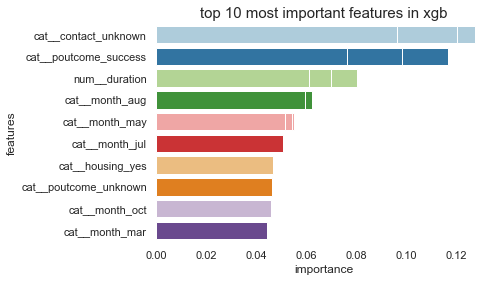

In [134]:
weights = [neg_to_pos_ratio, 16, 32]

for weight in weights:
    
    xgb = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=weight,
        n_estimators=200,
        max_leaves=20,
        learning_rate=0.03,
        gamma=0.03,
        min_child_weight=0.1,
        reg_lambda=0.3).fit(X_train_prepared, y_train)
    
    print(f'weight: {weight}')
    
    print('## train evaluation ##')
    y_train_pred = xgb.predict(X_train_prepared)
    print(classification_report(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    
    print('\n## test evaluation ##')
    y_test_pred = xgb.predict(X_test_prepared)
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
    
    print('-' * 60)
    
    feature_importance = pd.DataFrame({'features': preprocessor.get_feature_names_out(X_train.columns), 
                                   'importance': xgb.feature_importances_})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    sns.barplot(data=feature_importance[:10], y='features', x='importance')
    sns.despine(left=True, bottom=True)
    plt.title('top 10 most important features in xgb', fontsize=15);

### voting ensemble

In [56]:
svm = SVC(
    C=1, 
    gamma=0.1, 
    kernel='rbf', 
    class_weight='balanced')

ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(class_weight='balanced'), 
    n_estimators=50, 
    learning_rate=0.6)

xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=14,
    n_estimators=200,
    max_leaves=20,
    learning_rate=0.03,
    gamma=0.01,
    min_child_weight=0.01,
    reg_lambda=0.3)

combined = VotingClassifier(
    estimators=[
        ('svm', svm),
        ('ada', ada),
        ('xgboost', xgb)], 
    voting='hard')

cv_result = cross_val_score(combined, X_train_prepared, y_train, scoring='recall', cv=5)
print('recall:', round(cv_result.mean(), 3))

combined.fit(X_train_prepared, y_train)
y_test_pred = combined.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

recall: 0.861
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7985
           1       0.44      0.87      0.59      1058

    accuracy                           0.86      9043
   macro avg       0.71      0.86      0.75      9043
weighted avg       0.92      0.86      0.88      9043

[[6831 1154]
 [ 139  919]]


worse than xgboost.

### neural network

First, try tweak class weights to make the model pay more attention to the positive class.

In [82]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Total weights: {:.0f}'.format(pos * weight_for_1 + neg * weight_for_0))
print('Total samples: {:.0f}'.format(total))
# note that after tweaking, the sum of weights remains the same

Weight for class 0: 0.57
Weight for class 1: 4.27
Total weights: 36168
Total samples: 36168


In [83]:
weighted_model = build_model(
    num_features=train_features.shape[-1],
    output_bias=np.log(pos/neg))
weighted_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 61)]              0         
                                                                 
 dense_3 (Dense)             (None, 16)                992       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [84]:
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS*2,
    callbacks=[early_stopping],
    validation_data=(test_features, test_labels),
    class_weight=class_weight)

Epoch 1/200


2022-09-23 21:45:26.005470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 1.1106 - tp: 552.0000 - fp: 354.0000 - tn: 39568.0000 - fn: 4737.0000 - accuracy: 0.8874 - precision: 0.6093 - recall: 0.1044 - auc: 0.6381 - prc: 0.2511

2022-09-23 21:45:27.133264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 57ms/step - loss: 1.1106 - tp: 552.0000 - fp: 354.0000 - tn: 39568.0000 - fn: 4737.0000 - accuracy: 0.8874 - precision: 0.6093 - recall: 0.1044 - auc: 0.6381 - prc: 0.2511 - val_loss: 0.3702 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7985.0000 - val_fn: 1058.0000 - val_accuracy: 0.8830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5118 - val_prc: 0.1232
Epoch 2/200
18/18 [==============================] - 0s 18ms/step - loss: 0.9239 - tp: 14.0000 - fp: 91.0000 - tn: 31846.0000 - fn: 4217.0000 - accuracy: 0.8809 - precision: 0.1333 - recall: 0.0033 - auc: 0.5106 - prc: 0.1230 - val_loss: 0.4283 - val_tp: 3.0000 - val_fp: 32.0000 - val_tn: 7953.0000 - val_fn: 1055.0000 - val_accuracy: 0.8798 - val_precision: 0.0857 - val_recall: 0.0028 - val_auc: 0.5320 - val_prc: 0.1344
Epoch 3/200
18/18 [==============================] - 0s 16ms/step - loss: 0.7625 - tp: 619.0000 - fp: 3238.0000 - tn: 28699.0000 - fn: 3612.0000 - 

18/18 [==============================] - 0s 17ms/step - loss: 0.3609 - tp: 3745.0000 - fp: 5925.0000 - tn: 26012.0000 - fn: 486.0000 - accuracy: 0.8227 - precision: 0.3873 - recall: 0.8851 - auc: 0.9178 - prc: 0.5659 - val_loss: 0.3660 - val_tp: 931.0000 - val_fp: 1515.0000 - val_tn: 6470.0000 - val_fn: 127.0000 - val_accuracy: 0.8184 - val_precision: 0.3806 - val_recall: 0.8800 - val_auc: 0.9192 - val_prc: 0.5499
Epoch 40/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3607 - tp: 3747.0000 - fp: 6085.0000 - tn: 25852.0000 - fn: 484.0000 - accuracy: 0.8184 - precision: 0.3811 - recall: 0.8856 - auc: 0.9179 - prc: 0.5670 - val_loss: 0.3644 - val_tp: 932.0000 - val_fp: 1515.0000 - val_tn: 6470.0000 - val_fn: 126.0000 - val_accuracy: 0.8185 - val_precision: 0.3809 - val_recall: 0.8809 - val_auc: 0.9195 - val_prc: 0.5501
Epoch 41/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3587 - tp: 3765.0000 - fp: 6008.0000 - tn: 25929.0000 - fn: 466.0000 - acc

18/18 [==============================] - 0s 16ms/step - loss: 0.3363 - tp: 3816.0000 - fp: 5834.0000 - tn: 26103.0000 - fn: 415.0000 - accuracy: 0.8272 - precision: 0.3954 - recall: 0.9019 - auc: 0.9271 - prc: 0.5892 - val_loss: 0.3475 - val_tp: 948.0000 - val_fp: 1465.0000 - val_tn: 6520.0000 - val_fn: 110.0000 - val_accuracy: 0.8258 - val_precision: 0.3929 - val_recall: 0.8960 - val_auc: 0.9233 - val_prc: 0.5528
Epoch 78/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3345 - tp: 3848.0000 - fp: 5834.0000 - tn: 26103.0000 - fn: 383.0000 - accuracy: 0.8281 - precision: 0.3974 - recall: 0.9095 - auc: 0.9276 - prc: 0.5864 - val_loss: 0.3479 - val_tp: 949.0000 - val_fp: 1457.0000 - val_tn: 6528.0000 - val_fn: 109.0000 - val_accuracy: 0.8268 - val_precision: 0.3944 - val_recall: 0.8970 - val_auc: 0.9235 - val_prc: 0.5534
Epoch 79/200
18/18 [==============================] - 0s 16ms/step - loss: 0.3372 - tp: 3832.0000 - fp: 5849.0000 - tn: 26088.0000 - fn: 399.0000 - acc

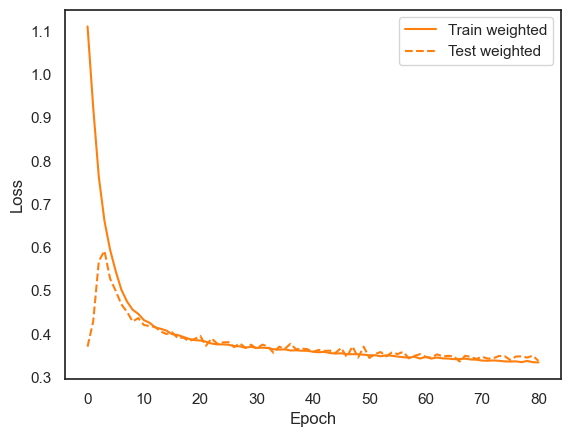

In [85]:
plot_loss(weighted_history, 'weighted', 1)

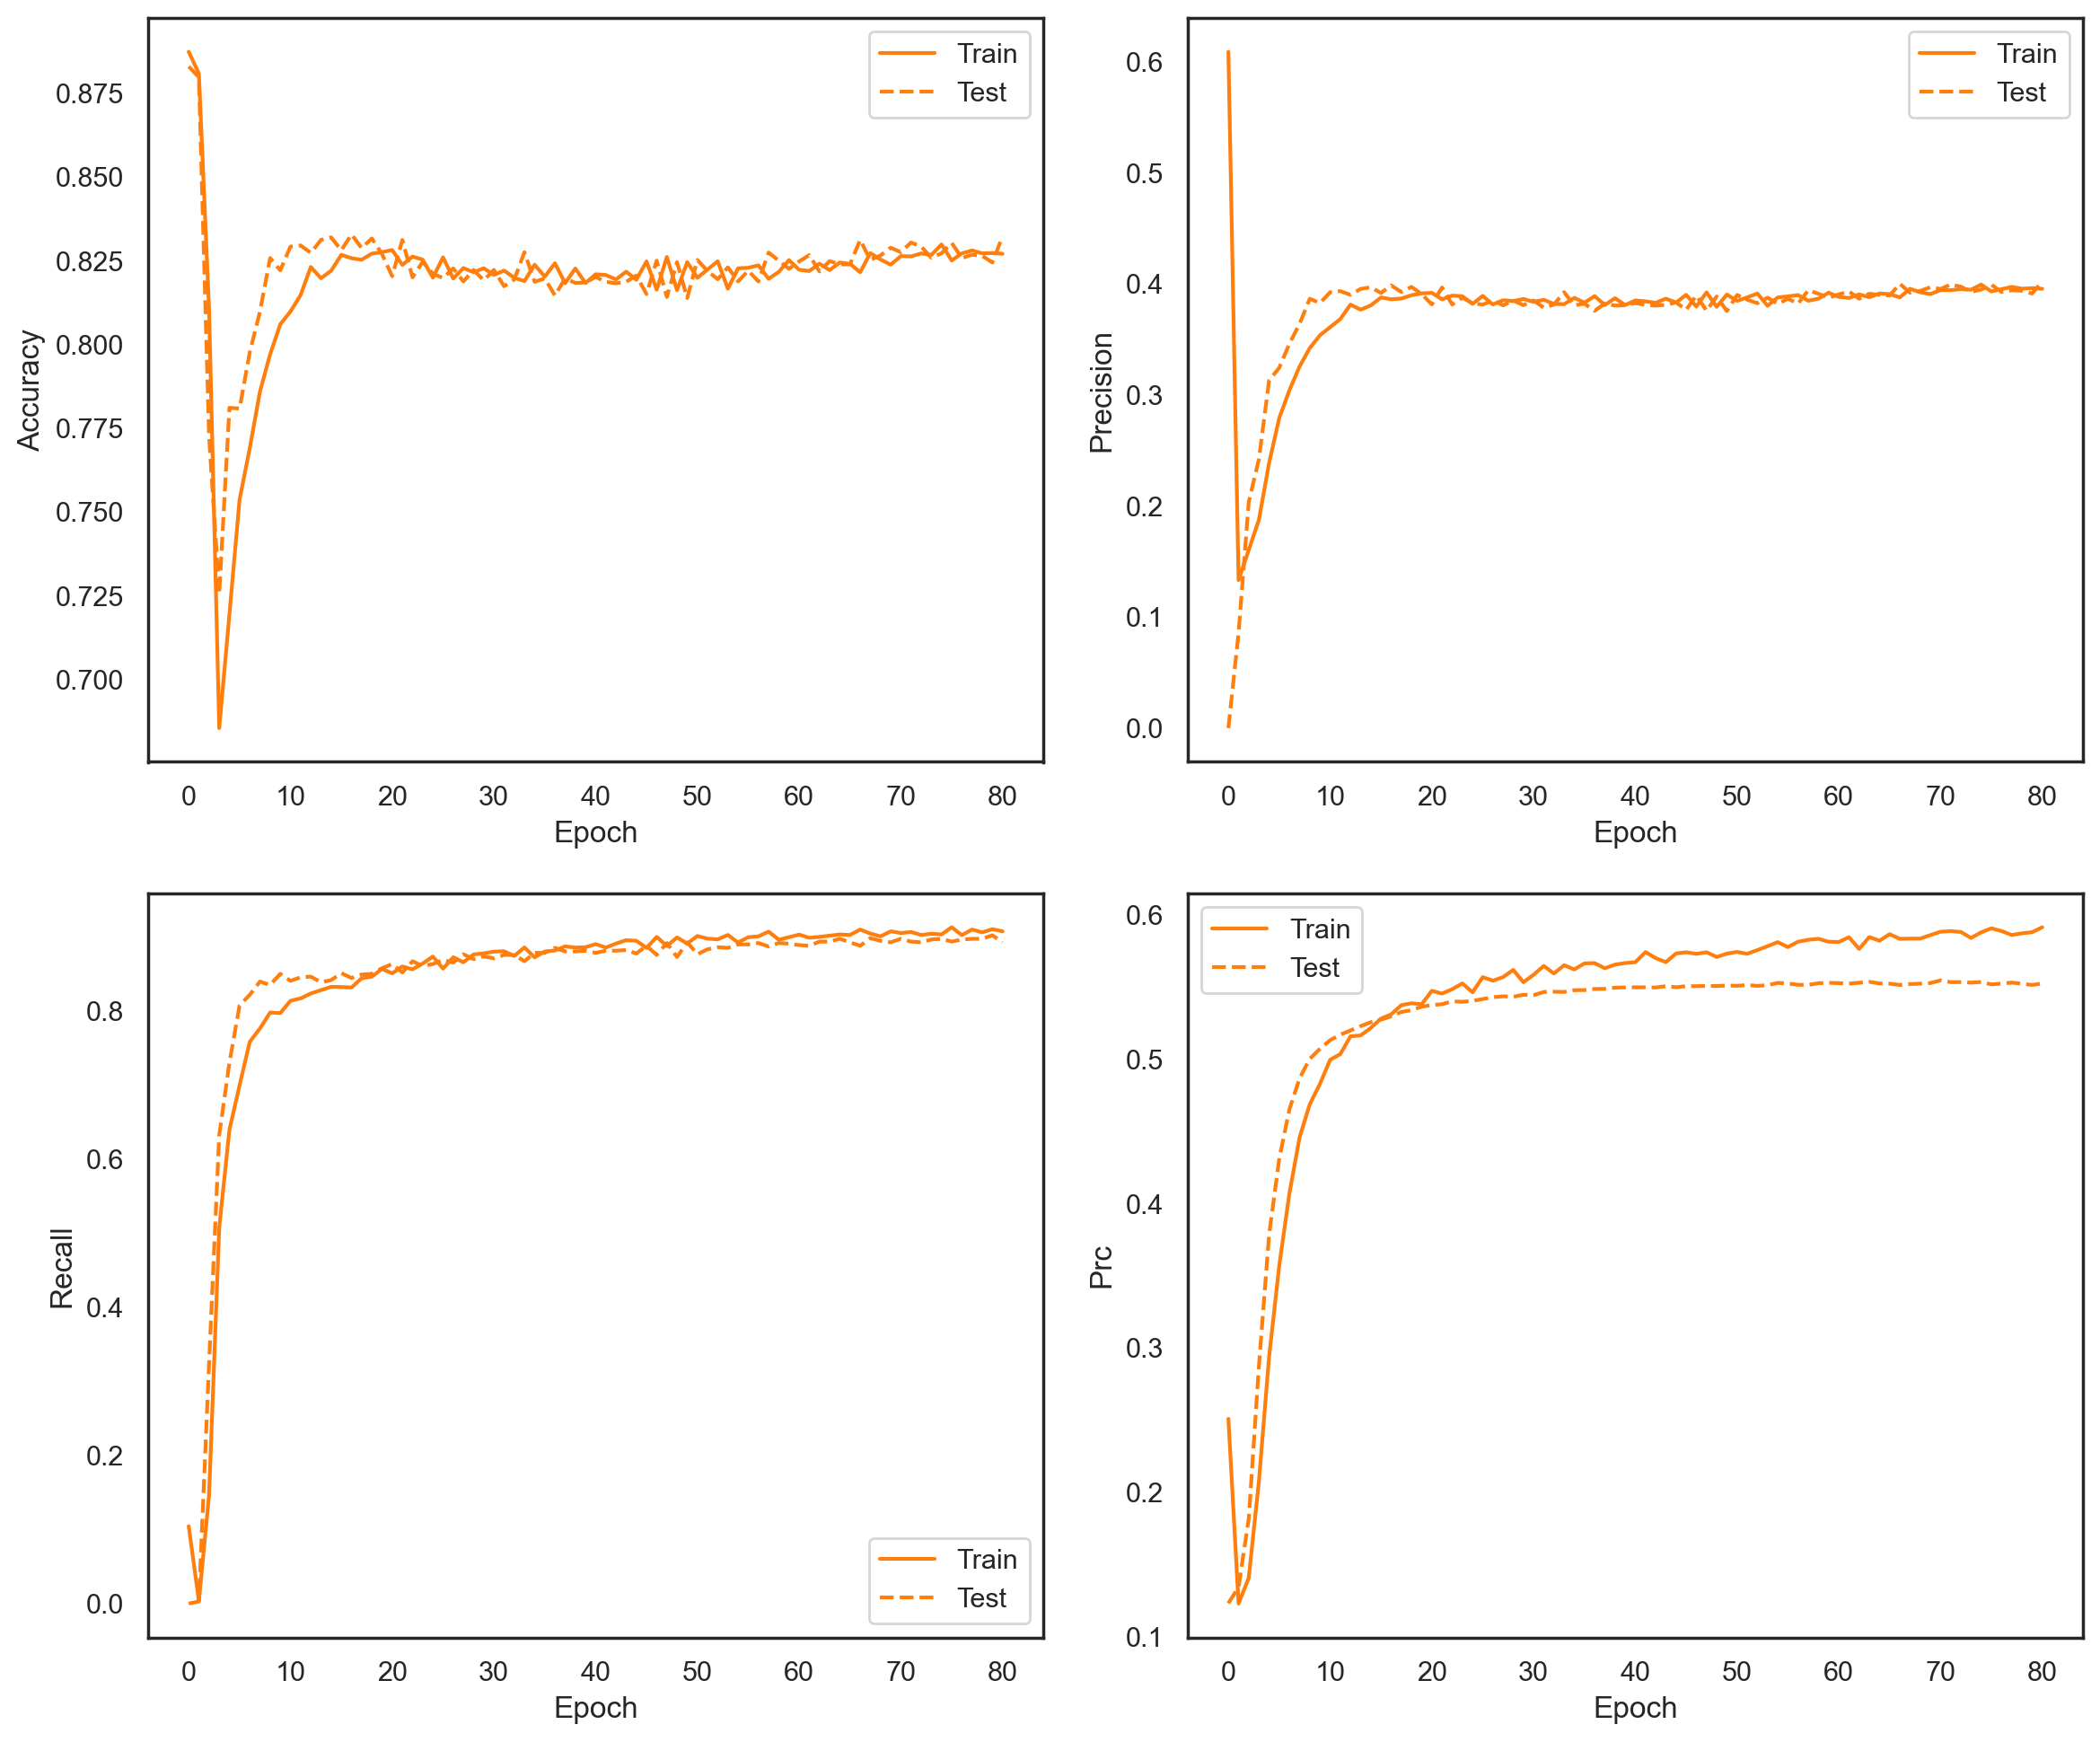

In [86]:
plot_metrics(weighted_history)

In [87]:
weighted_results = weighted_model.evaluate(X_test_prepared.toarray(), 
                                           y_test,
                                           batch_size=BATCH_SIZE, 
                                           verbose=0)
print('Evaluation of weighted nn model')
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ':', value)

2022-09-23 21:45:52.523445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Evaluation of weighted nn model
loss : 0.3468111753463745
tp : 949.0
fp : 1450.0
tn : 6535.0
fn : 109.0
accuracy : 0.827601432800293
precision : 0.3955814838409424
recall : 0.8969754576683044
auc : 0.9231138825416565
prc : 0.5549547672271729


In [88]:
weighted_train_pred = weighted_model.predict(X_train_prepared.toarray())
weighted_test_pred = weighted_model.predict(X_test_prepared.toarray())

 134/1131 [==>...........................] - ETA: 1s

2022-09-23 21:45:53.159402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


283/283 [==============================] - 0s 1ms/step


Compared to baseline nn, we sacrificed accuracy and precision to obtain a higher recall on the positive class.

# 7 - Resampling <a name='7'></a>

## Oversampling<a name='7.1'></a>

In [89]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter

## random oversampling <a name='7.1.1'></a>

In [94]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 31937), (1, 31937)]


In [95]:
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, scoring='recall', cv=5)
xgb_scores.mean()

0.9696278416190369

In [96]:
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      7985
           1       0.48      0.81      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.73      0.85      0.76      9043
weighted avg       0.91      0.87      0.89      9043

[[7057  928]
 [ 205  853]]


Overfitting the positive class, and not much improvement compared to unsampled result.

### SMOTE <a name='7.1.2'></a>

In [118]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 31937), (1, 31937)]


In [119]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)

print('## train evaluation ##')
y_resampled_pred = xgb.predict(X_resampled)
print(classification_report(y_resampled, y_resampled_pred))
print(confusion_matrix(y_resampled, y_resampled_pred))

print('\n## test evaluation ##')
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

## train evaluation ##
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     31937
           1       0.97      0.95      0.96     31937

    accuracy                           0.96     63874
   macro avg       0.96      0.96      0.96     63874
weighted avg       0.96      0.96      0.96     63874

[[30934  1003]
 [ 1680 30257]]

## test evaluation ##
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.61      0.54      0.57      1058

    accuracy                           0.91      9043
   macro avg       0.77      0.75      0.76      9043
weighted avg       0.90      0.91      0.90      9043

[[7618  367]
 [ 490  568]]


This is worse than baseline xgboost on original dataset, becasue we are overfitting the resampled traning dataset. Tried a few hyperparameters tuning, didn't get better result.

Let us try neural network model on resampled data.

In [120]:
# here we don't need to tweak output bias, 0 is fine.
resampled_model = build_model(num_features=train_features.shape[-1])
resampled_history = resampled_model.fit(
    X_resampled.toarray(),
    np.array(y_resampled),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS*2,
    callbacks=[early_stopping],
    validation_data=(test_features, test_labels))

Epoch 1/200


2022-09-23 22:12:40.649185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.7070 - tp: 2484.0000 - fp: 1093.0000 - tn: 38829.0000 - fn: 30511.0000 - accuracy: 0.5666 - precision: 0.6944 - recall: 0.0753 - auc: 0.6387 - prc: 0.5829

2022-09-23 22:12:42.370656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 3s 56ms/step - loss: 0.7070 - tp: 2484.0000 - fp: 1093.0000 - tn: 38829.0000 - fn: 30511.0000 - accuracy: 0.5666 - precision: 0.6944 - recall: 0.0753 - auc: 0.6387 - prc: 0.5829 - val_loss: 0.5554 - val_tp: 383.0000 - val_fp: 787.0000 - val_tn: 7198.0000 - val_fn: 675.0000 - val_accuracy: 0.8383 - val_precision: 0.3274 - val_recall: 0.3620 - val_auc: 0.7611 - val_prc: 0.2898
Epoch 2/200
32/32 [==============================] - 1s 16ms/step - loss: 0.5909 - tp: 18847.0000 - fp: 6392.0000 - tn: 25545.0000 - fn: 13090.0000 - accuracy: 0.6950 - precision: 0.7467 - recall: 0.5901 - auc: 0.7887 - prc: 0.7640 - val_loss: 0.4962 - val_tp: 803.0000 - val_fp: 1601.0000 - val_tn: 6384.0000 - val_fn: 255.0000 - val_accuracy: 0.7948 - val_precision: 0.3340 - val_recall: 0.7590 - val_auc: 0.8573 - val_prc: 0.4175
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.4931 - tp: 24715.0000 - fp: 7223.0000 - tn: 24714.0000 - fn: 7222.0000 -

Epoch 20/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3222 - tp: 29242.0000 - fp: 5758.0000 - tn: 26179.0000 - fn: 2695.0000 - accuracy: 0.8677 - precision: 0.8355 - recall: 0.9156 - auc: 0.9304 - prc: 0.9066 - val_loss: 0.3518 - val_tp: 920.0000 - val_fp: 1441.0000 - val_tn: 6544.0000 - val_fn: 138.0000 - val_accuracy: 0.8254 - val_precision: 0.3897 - val_recall: 0.8696 - val_auc: 0.9190 - val_prc: 0.5533
Epoch 21/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3208 - tp: 29232.0000 - fp: 5724.0000 - tn: 26213.0000 - fn: 2705.0000 - accuracy: 0.8680 - precision: 0.8363 - recall: 0.9153 - auc: 0.9308 - prc: 0.9080 - val_loss: 0.3539 - val_tp: 923.0000 - val_fp: 1442.0000 - val_tn: 6543.0000 - val_fn: 135.0000 - val_accuracy: 0.8256 - val_precision: 0.3903 - val_recall: 0.8724 - val_auc: 0.9196 - val_prc: 0.5558
Epoch 22/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3190 - tp: 29293.0000 - fp: 5715.0000 - tn: 26222.0000 - 

Epoch 39/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3040 - tp: 29505.0000 - fp: 5471.0000 - tn: 26466.0000 - fn: 2432.0000 - accuracy: 0.8763 - precision: 0.8436 - recall: 0.9239 - auc: 0.9368 - prc: 0.9154 - val_loss: 0.3408 - val_tp: 931.0000 - val_fp: 1365.0000 - val_tn: 6620.0000 - val_fn: 127.0000 - val_accuracy: 0.8350 - val_precision: 0.4055 - val_recall: 0.8800 - val_auc: 0.9213 - val_prc: 0.5642
Epoch 40/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3034 - tp: 29541.0000 - fp: 5508.0000 - tn: 26429.0000 - fn: 2396.0000 - accuracy: 0.8763 - precision: 0.8428 - recall: 0.9250 - auc: 0.9370 - prc: 0.9153 - val_loss: 0.3347 - val_tp: 926.0000 - val_fp: 1335.0000 - val_tn: 6650.0000 - val_fn: 132.0000 - val_accuracy: 0.8378 - val_precision: 0.4096 - val_recall: 0.8752 - val_auc: 0.9213 - val_prc: 0.5654
Epoch 41/200
32/32 [==============================] - 0s 15ms/step - loss: 0.3015 - tp: 29566.0000 - fp: 5415.0000 - tn: 26522.0000 - 

Epoch 58/200
32/32 [==============================] - 0s 15ms/step - loss: 0.2936 - tp: 29486.0000 - fp: 5181.0000 - tn: 26756.0000 - fn: 2451.0000 - accuracy: 0.8805 - precision: 0.8505 - recall: 0.9233 - auc: 0.9405 - prc: 0.9205 - val_loss: 0.3326 - val_tp: 927.0000 - val_fp: 1276.0000 - val_tn: 6709.0000 - val_fn: 131.0000 - val_accuracy: 0.8444 - val_precision: 0.4208 - val_recall: 0.8762 - val_auc: 0.9224 - val_prc: 0.5725
Epoch 59/200
32/32 [==============================] - 0s 15ms/step - loss: 0.2919 - tp: 29540.0000 - fp: 5140.0000 - tn: 26797.0000 - fn: 2397.0000 - accuracy: 0.8820 - precision: 0.8518 - recall: 0.9249 - auc: 0.9412 - prc: 0.9211 - val_loss: 0.3290 - val_tp: 921.0000 - val_fp: 1262.0000 - val_tn: 6723.0000 - val_fn: 137.0000 - val_accuracy: 0.8453 - val_precision: 0.4219 - val_recall: 0.8705 - val_auc: 0.9226 - val_prc: 0.5725
Epoch 60/200
32/32 [==============================] - 0s 15ms/step - loss: 0.2924 - tp: 29518.0000 - fp: 5170.0000 - tn: 26767.0000 - 

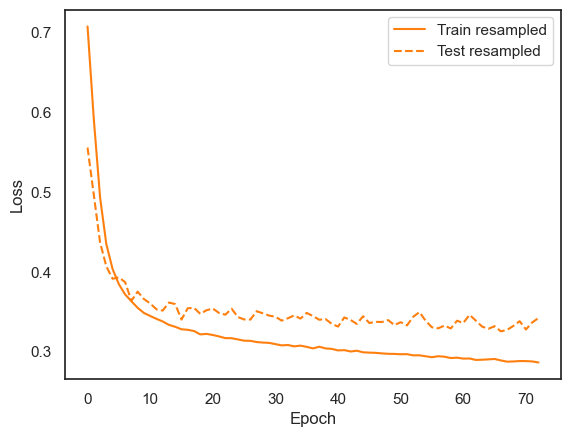

In [121]:
plot_loss(resampled_history, 'resampled', n=1)

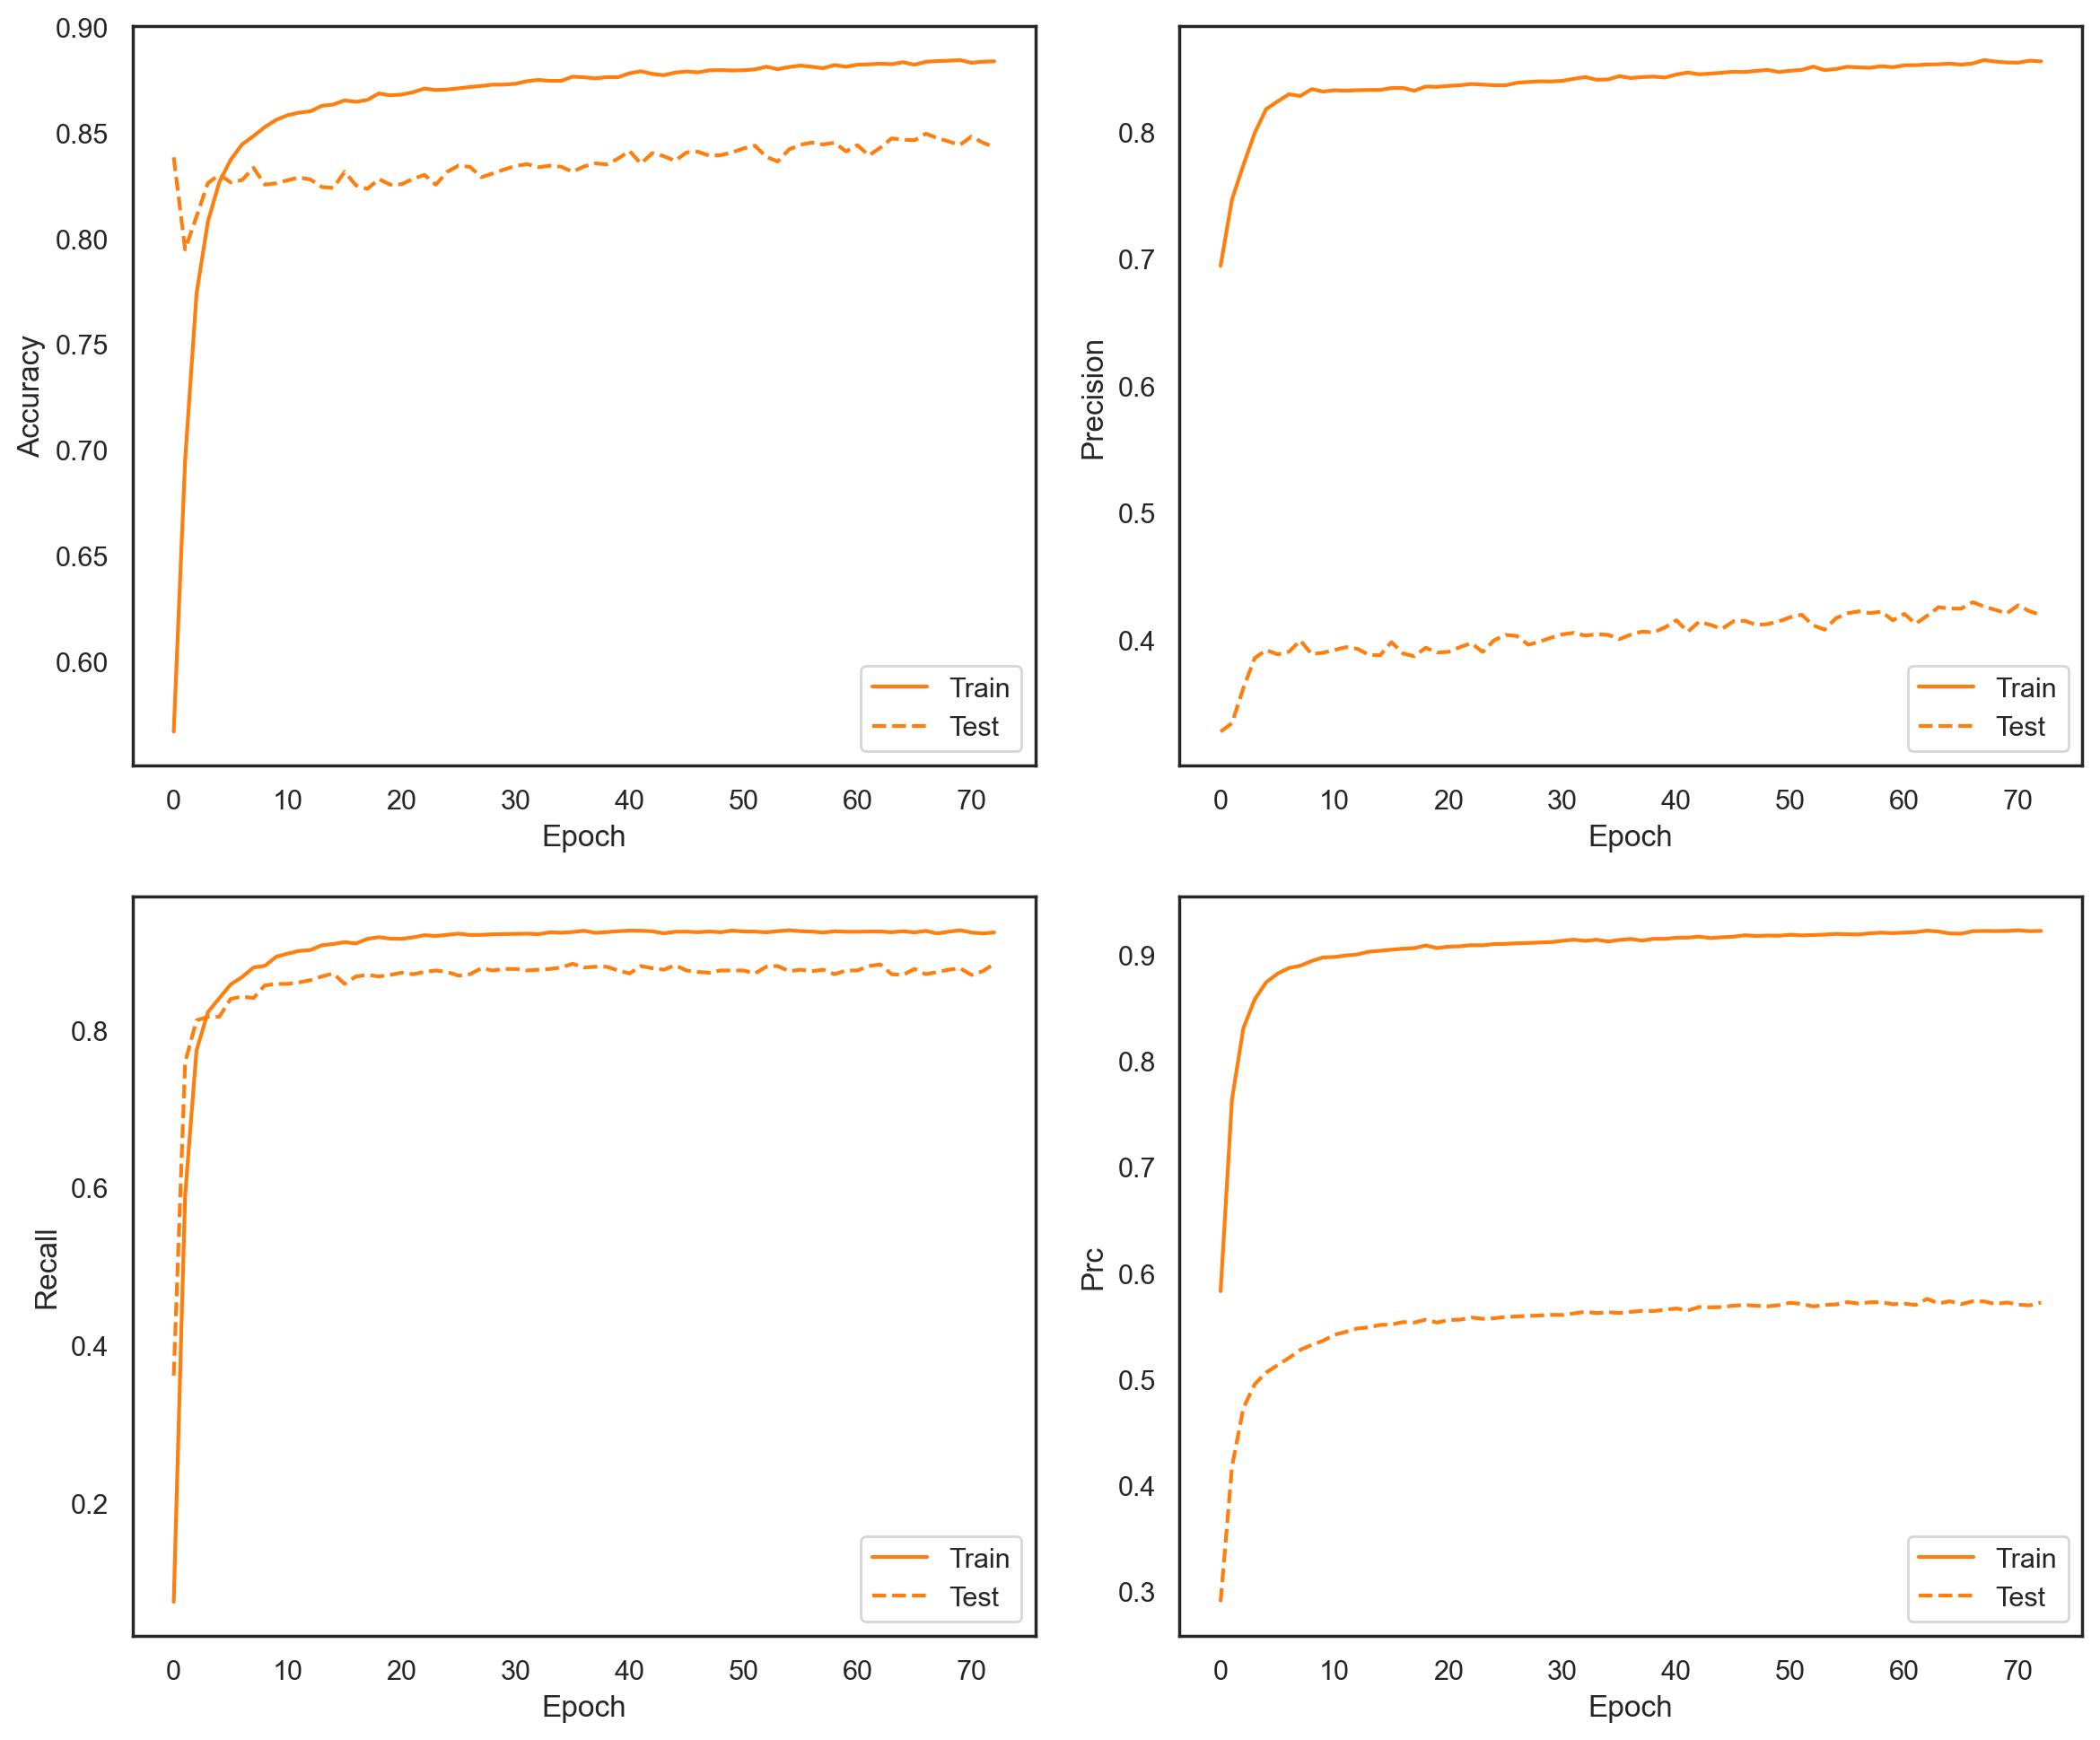

In [122]:
plot_metrics(resampled_history)

In [123]:
resampled_results = resampled_model.evaluate(X_test_prepared.toarray(), 
                                             y_test,
                                             batch_size=BATCH_SIZE, 
                                             verbose=0)
print('Evaluation of resampled model')
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ':', value)

2022-09-23 22:13:19.512316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Evaluation of resampled model
loss : 0.3387858271598816
tp : 934.0
fp : 1297.0
tn : 6688.0
fn : 124.0
accuracy : 0.8428618907928467
precision : 0.41864633560180664
recall : 0.8827977776527405
auc : 0.9229264259338379
prc : 0.5757114887237549


In [124]:
resampled_train_pred = resampled_model.predict(X_resampled.toarray())
resampled_test_pred = resampled_model.predict(X_test_prepared.toarray())

 136/1997 [=>............................] - ETA: 2s

2022-09-23 22:13:20.274783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


283/283 [==============================] - 0s 1ms/step


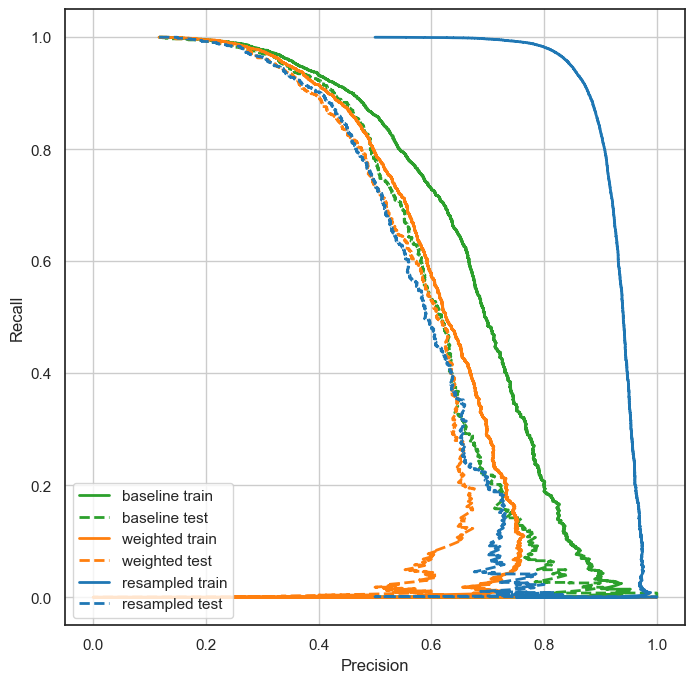

In [144]:
fig = plt.figure(figsize=(8, 8), dpi=100)
plot_prc('baseline train', y_train, baseline_train_pred, color=colors[2])
plot_prc('baseline test', y_test, baseline_test_pred, color=colors[2], linestyle='--')
plot_prc('weighted train', y_train, weighted_train_pred, color=colors[1])
plot_prc('weighted test', y_test, weighted_test_pred, color=colors[1], linestyle='--')
plot_prc('resampled train', y_resampled, resampled_train_pred, color=colors[0])
plot_prc('resampled test', y_test, resampled_test_pred, color=colors[0], linestyle='--')
plt.legend(loc='lower left');

### ADASYN <a name='7.1.3'></a>

In [105]:
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 31937), (1, 31951)]


In [106]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7985
           1       0.61      0.52      0.56      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.74      0.76      9043
weighted avg       0.90      0.91      0.90      9043

[[7638  347]
 [ 507  551]]


## Undersampling<a name='7.2'></a>

In [107]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

### Random undersamping <a name='7.2.1'></a>

In [108]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 4231), (1, 4231)]


In [109]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7985
           1       0.43      0.89      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6718 1267]
 [ 118  940]]


### Tomek's link<a name='7.2.2'></a>

In [110]:
tomek = TomekLinks(sampling_strategy='majority')
X_resampled, y_resampled = rus.fit_resample(X_train_prepared, y_train)
print('before resample:', sorted(Counter(y_train).items()))
print('after resample:', sorted(Counter(y_resampled).items()))

before resample: [(0, 31937), (1, 4231)]
after resample: [(0, 4231), (1, 4231)]


In [111]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)

print('## train evaluation ##')
y_resampled_pred = xgb.predict(X_resampled)
print(classification_report(y_resampled, y_resampled_pred))
print(confusion_matrix(y_resampled, y_resampled_pred))

print('\n## test evaluation ##')
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

## train evaluation ##
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4231
           1       0.95      0.97      0.96      4231

    accuracy                           0.96      8462
   macro avg       0.96      0.96      0.96      8462
weighted avg       0.96      0.96      0.96      8462

[[4017  214]
 [ 116 4115]]

## test evaluation ##
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7985
           1       0.43      0.89      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.86      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6718 1267]
 [ 118  940]]


In [112]:
# since it's overfitting the resampled training set, let's set some regularization parameters
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    max_leaves=20,
    learning_rate=0.1,
    min_child_weight=0.5,
    gamma=0.1).fit(X_resampled, y_resampled)

print('## train evaluation ##')
y_resampled_pred = xgb.predict(X_resampled)
print(classification_report(y_resampled, y_resampled_pred))
print(confusion_matrix(y_resampled, y_resampled_pred))

print('\n## test evaluation ##')
y_test_pred = xgb.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

## train evaluation ##
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4231
           1       0.93      0.96      0.94      4231

    accuracy                           0.94      8462
   macro avg       0.94      0.94      0.94      8462
weighted avg       0.94      0.94      0.94      8462

[[3911  320]
 [ 179 4052]]

## test evaluation ##
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7985
           1       0.43      0.90      0.58      1058

    accuracy                           0.85      9043
   macro avg       0.71      0.87      0.74      9043
weighted avg       0.92      0.85      0.87      9043

[[6724 1261]
 [ 109  949]]


still overfitting the resampled training set but slightly better.